In [116]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import itertools as it
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import pdist, squareform
import random

from matplotlib.colors import LogNorm
from sklearn.metrics import silhouette_score

## Первичная обработка данных

In [117]:
Y = pd.read_excel("data/Y_4_14.xlsx", names=[f"feature_{i}" for i in range(4)])

In [118]:
Y.describe()

,feature_0,feature_1,feature_2,feature_3
count,199.000000,199.000000,199.000000,199.000000
mean,1.386574,0.677253,1.069229,0.976083
std,0.514729,0.498448,0.878040,0.148064
min,0.627841,-0.832312,-0.307301,0.543181
25%,0.944193,0.172155,0.076118,0.896790
50%,1.123321,0.918105,1.063232,0.978444
75%,1.967255,1.036559,1.926249,1.050990
max,2.275134,1.349070,2.520664,1.482438


#### Проверка на выбросы

In [119]:
Y.isna().sum()

feature_0    0
feature_1    0
feature_2    0
feature_3    0
dtype: int64

<AxesSubplot: >

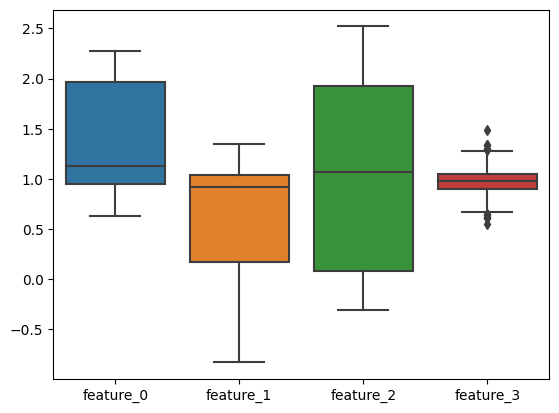

In [120]:
sns.boxplot(Y)

In [122]:
Y = MinMaxScaler().fit_transform(Y)

<AxesSubplot: >

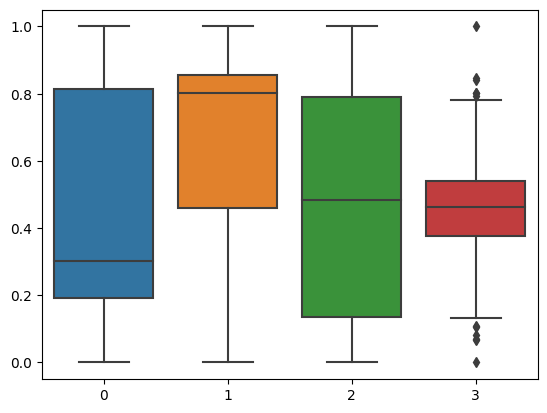

In [123]:
sns.boxplot(Y)

По боксплотам видно, что в наблюдениях имеются выбросы по одной из координат

In [124]:
Y_df = pd.DataFrame(data=Y, columns=[f'feature_{i}' for i in range(Y.shape[1])])
Y_df.describe()

,feature_0,feature_1,feature_2,feature_3
count,199.000000,199.000000,199.000000,199.000000
mean,0.460594,0.692022,0.486757,0.460898
std,0.312470,0.228501,0.310485,0.157640
min,0.000000,0.000000,0.000000,0.000000
25%,0.192044,0.460473,0.135581,0.376477
50%,0.300784,0.802435,0.484636,0.463411
75%,0.813100,0.856737,0.789808,0.540650
max,1.000000,1.000000,1.000000,1.000000


In [125]:
q3 = np.quantile(Y_df['feature_3'], 0.75)
q1 = np.quantile(Y_df['feature_3'], 0.25)
IQR = q3 - q1

outliers = list(Y_df[(Y_df['feature_3'] <= q1 - 1.5*IQR) | (Y_df['feature_3'] >= q3 + 1.5*IQR)].index)

Вложим наши наблюдения на двумерие с помощью PCA для визуализации

In [126]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data_2d = pca.fit_transform(Y)

<AxesSubplot: title={'center': 'Двумерная карта наблюдений'}, xlabel='pca_feature1', ylabel='pca_feature2'>

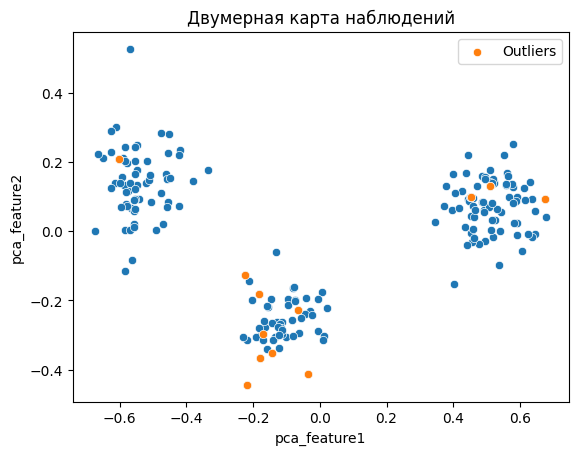

In [127]:
plt.title('Двумерная карта наблюдений')
plt.xlabel('pca_feature1')
plt.ylabel('pca_feature2')
sns.scatterplot(x=data_2d[:, 0], y=data_2d[:, 1])

sns.scatterplot(x=data_2d[outliers, 0], y=data_2d[outliers, 1], label='Outliers')

На двумерной карте визуально легко выделить 3 кластера. Также на карте отмечены выбросы, найденные ранее, они вполне вписываются в кластерную структуру и лежат внутри кластеров, а не где-то между ними, поэтому не будем их удалять.

## Подготовка данных, для начала возьмем евклидово расстояние

#### Вычисление матрицы расстояний

In [128]:
def get_dist_matrix(matrix, metric="euclidean"):
    if metric == "minkowski":
        dist_vector = pdist(matrix, metric=metric, p=4)
    else:
        dist_vector = pdist(matrix, metric=metric)
    return squareform(dist_vector)

In [129]:
d_matrix_euclidean = get_dist_matrix(Y, metric="euclidean")

#### Вычисление similarity-матрицы 

In [130]:
def get_similarity_matrix(d_matrix):
    sim_matrix = 1 / (1 + d_matrix)
    return sim_matrix

In [131]:
sim_matrix = get_similarity_matrix(d_matrix_euclidean)

<AxesSubplot: >

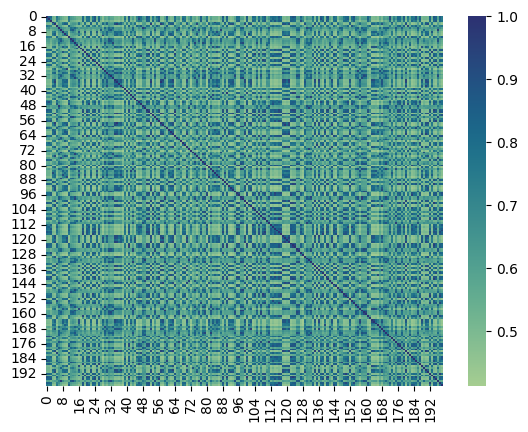

In [132]:
sns.heatmap(sim_matrix, cmap="crest")

Таким образом мы перешли к графовой модели, представленной матрицей схожести. Наблюдения из начальной таблицы стали вершинами графа, а схожесть наблюдений с индексами i и j - ребрами. Значение элемента [i, j] матрицы sim_matrix является весов ребра в нашем графе.

## Кластеризация для числа кластеров k=2

#### Кластеризация методом MST

Для кластеризации этим методом мы используем библиотеку networkx. Мы инициализируем граф и находим для него MST с помощью метода maximum_spanning_tree из этой библиотеки. Этот метод использует алгоритм Краскала для нахождения MST.

In [133]:
def MST_clustering(n_clusters):
    G = nx.Graph()
    num_points = Y.shape[0]

    # Добавляем узлы
    G.add_nodes_from(range(num_points))

    # Добавляем рёбра с весами
    for i in range(num_points):
        for j in range(i + 1, num_points):
            G.add_edge(i, j, weight=sim_matrix[i, j])

    # Построение максимального остовного дерева (MST) алгоритмом Краскала
    mst = nx.maximum_spanning_tree(G)

    # Удаление самого короткого ребра
    for i in range(n_clusters - 1):
        sorted_edges = sorted(mst.edges(data=True), key=lambda x: x[2]["weight"])
        shortest_edge = sorted_edges[0]  # самое короткое ребро
        mst.remove_edge(shortest_edge[0], shortest_edge[1])

    # Получаем компоненты связности
    clusters_mst = list(nx.connected_components(mst))

    # Визуализация
    plt.figure(figsize=(8, 6))

    # Рисуем MST
    plt.figure(figsize=(30, 40))
    plt.title("Граф MST с удаленным минимальным ребром")
    nx.draw_planar(mst, node_color="skyblue", edge_color="blue", with_labels=True, width=2)
    plt.show()

    plt.figure(figsize=(25, 15))

    for i, cluster in enumerate(clusters_mst, start=1):
        subgraph = mst.subgraph(cluster)  # Создаём подграф для кластера

        plt.subplot(1, n_clusters, i)
        nx.draw_planar(
            subgraph,
            with_labels=True,
            node_color="skyblue",
            edge_color="blue",
            node_size=700,
            font_weight="bold",
        )
        plt.title(f"Граф кластера {i}")
        plt.xlabel("X")
        plt.ylabel("Y")

    plt.tight_layout()
    plt.show()

    for i, cluster in enumerate(clusters_mst, start=1):
        print(f"Кластер {i}: {sorted(cluster)}")

    return G, clusters_mst

<Figure size 800x600 with 0 Axes>

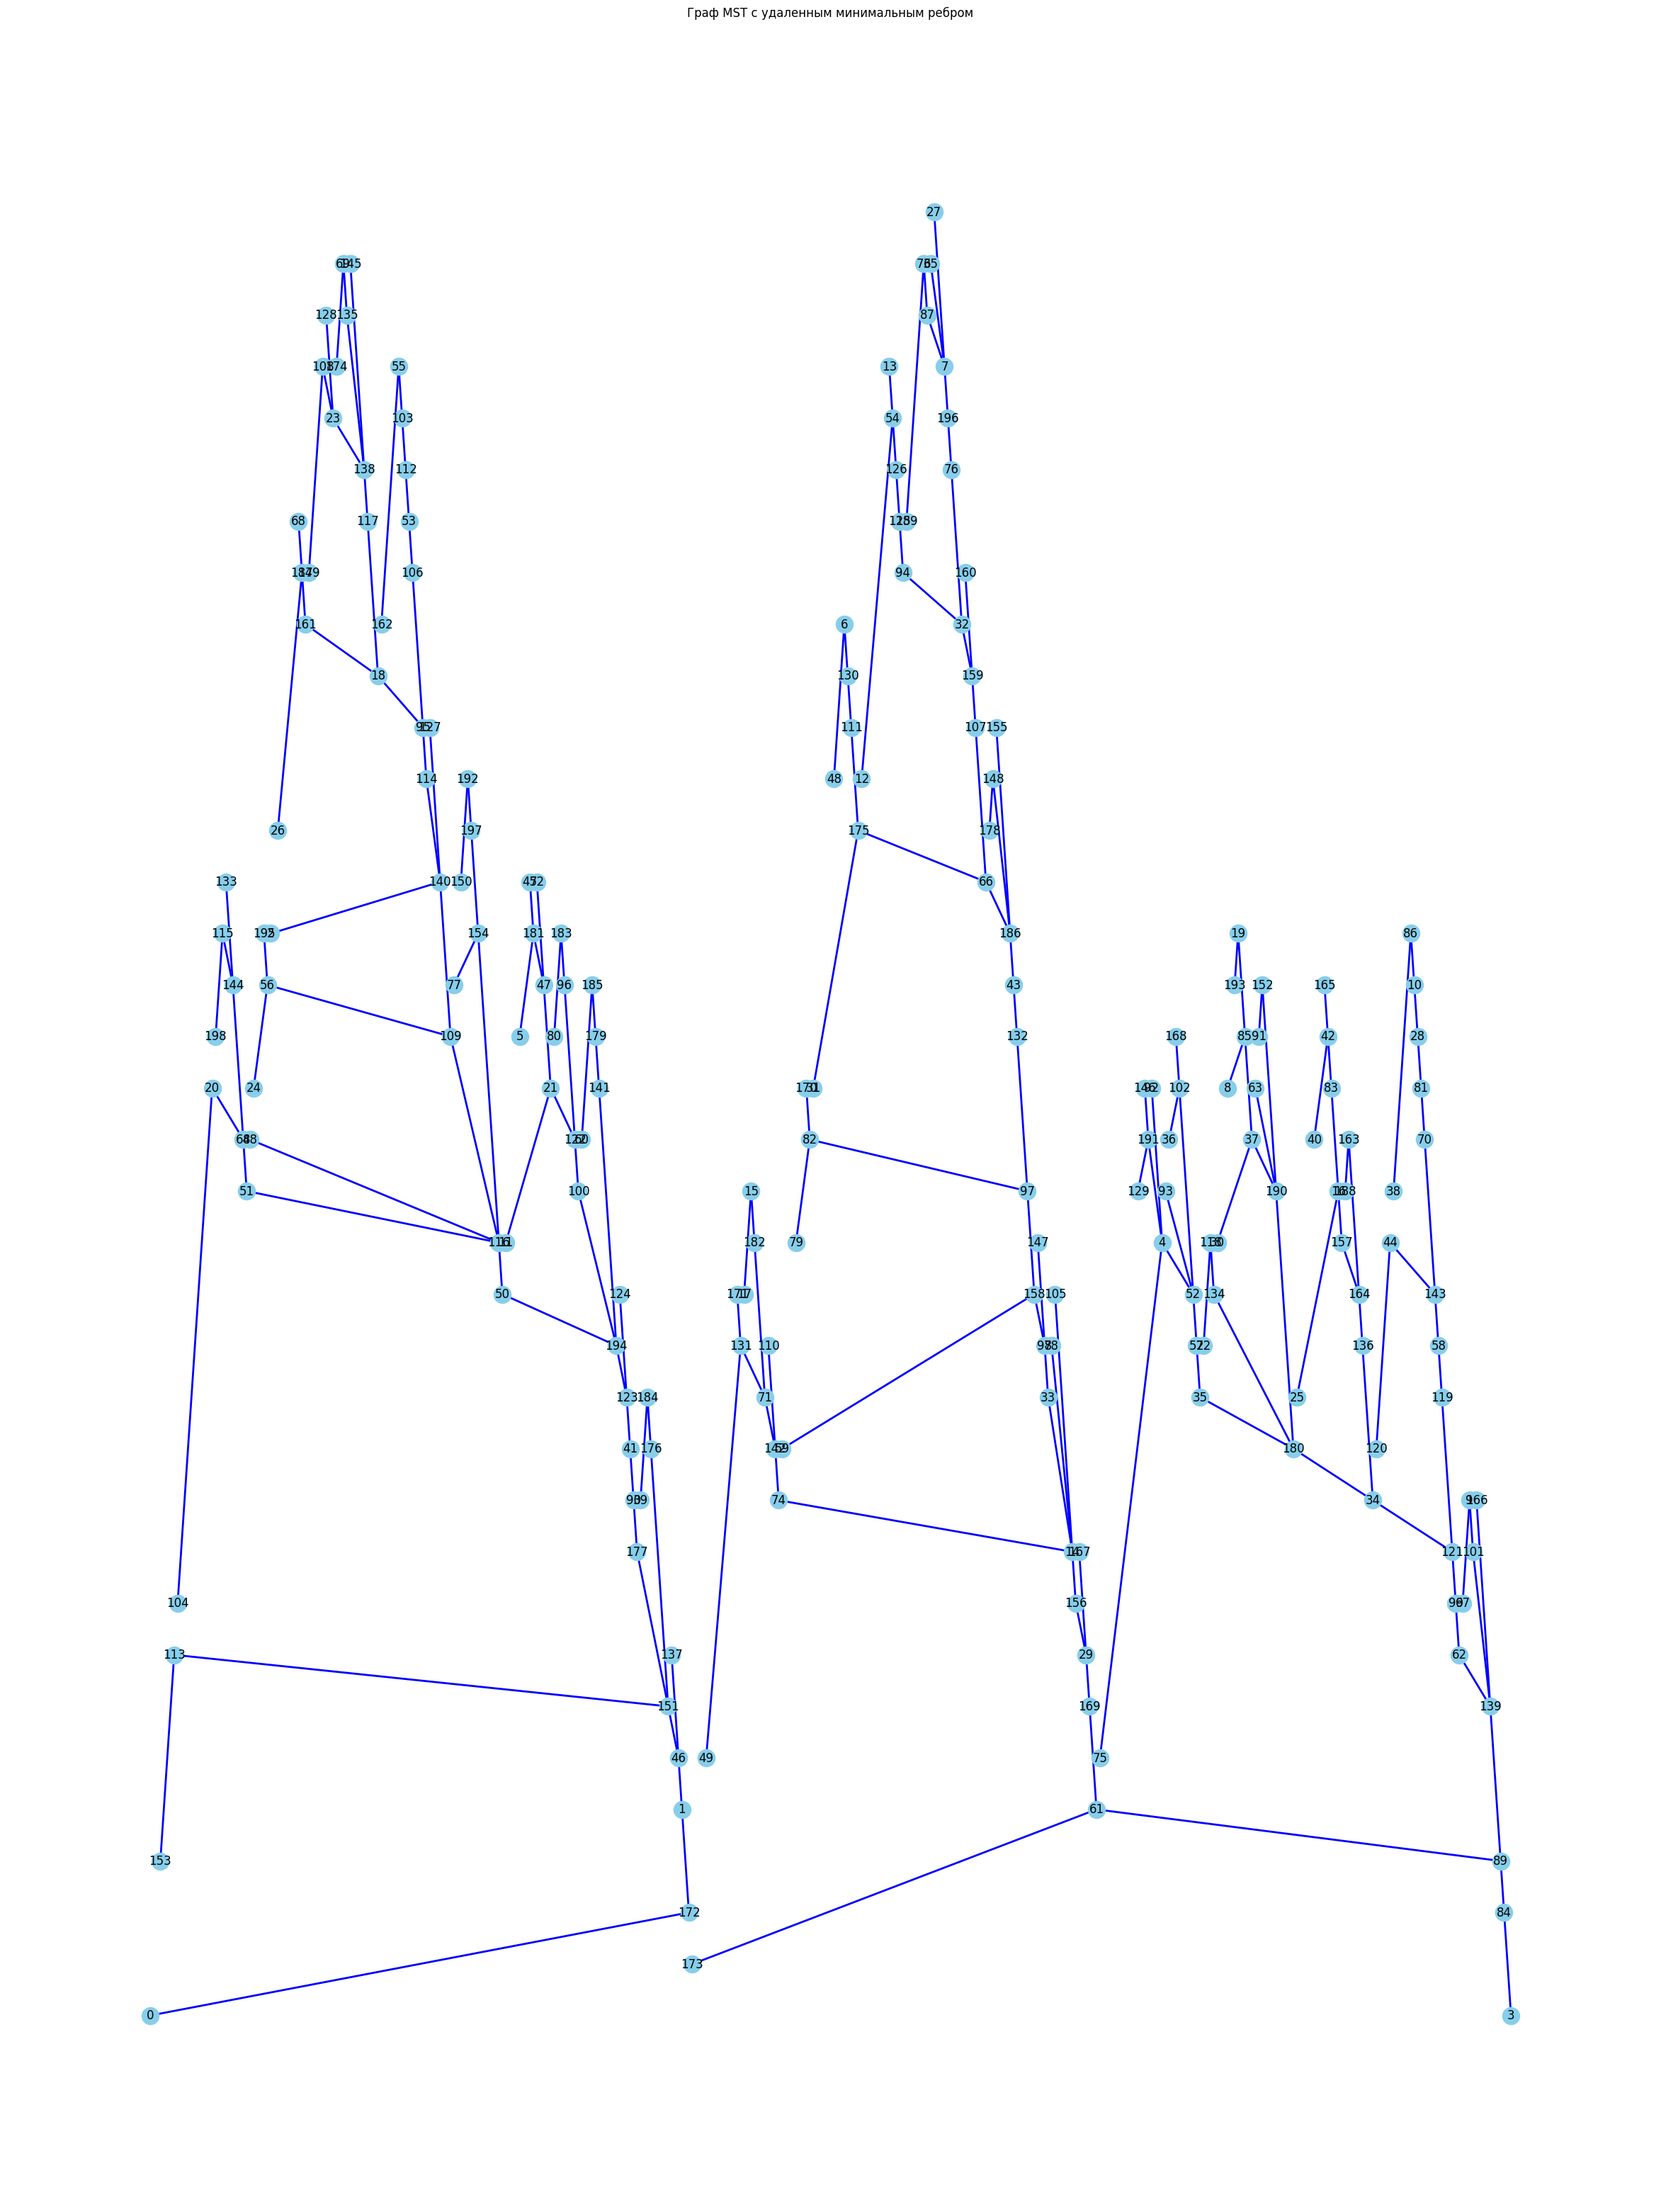

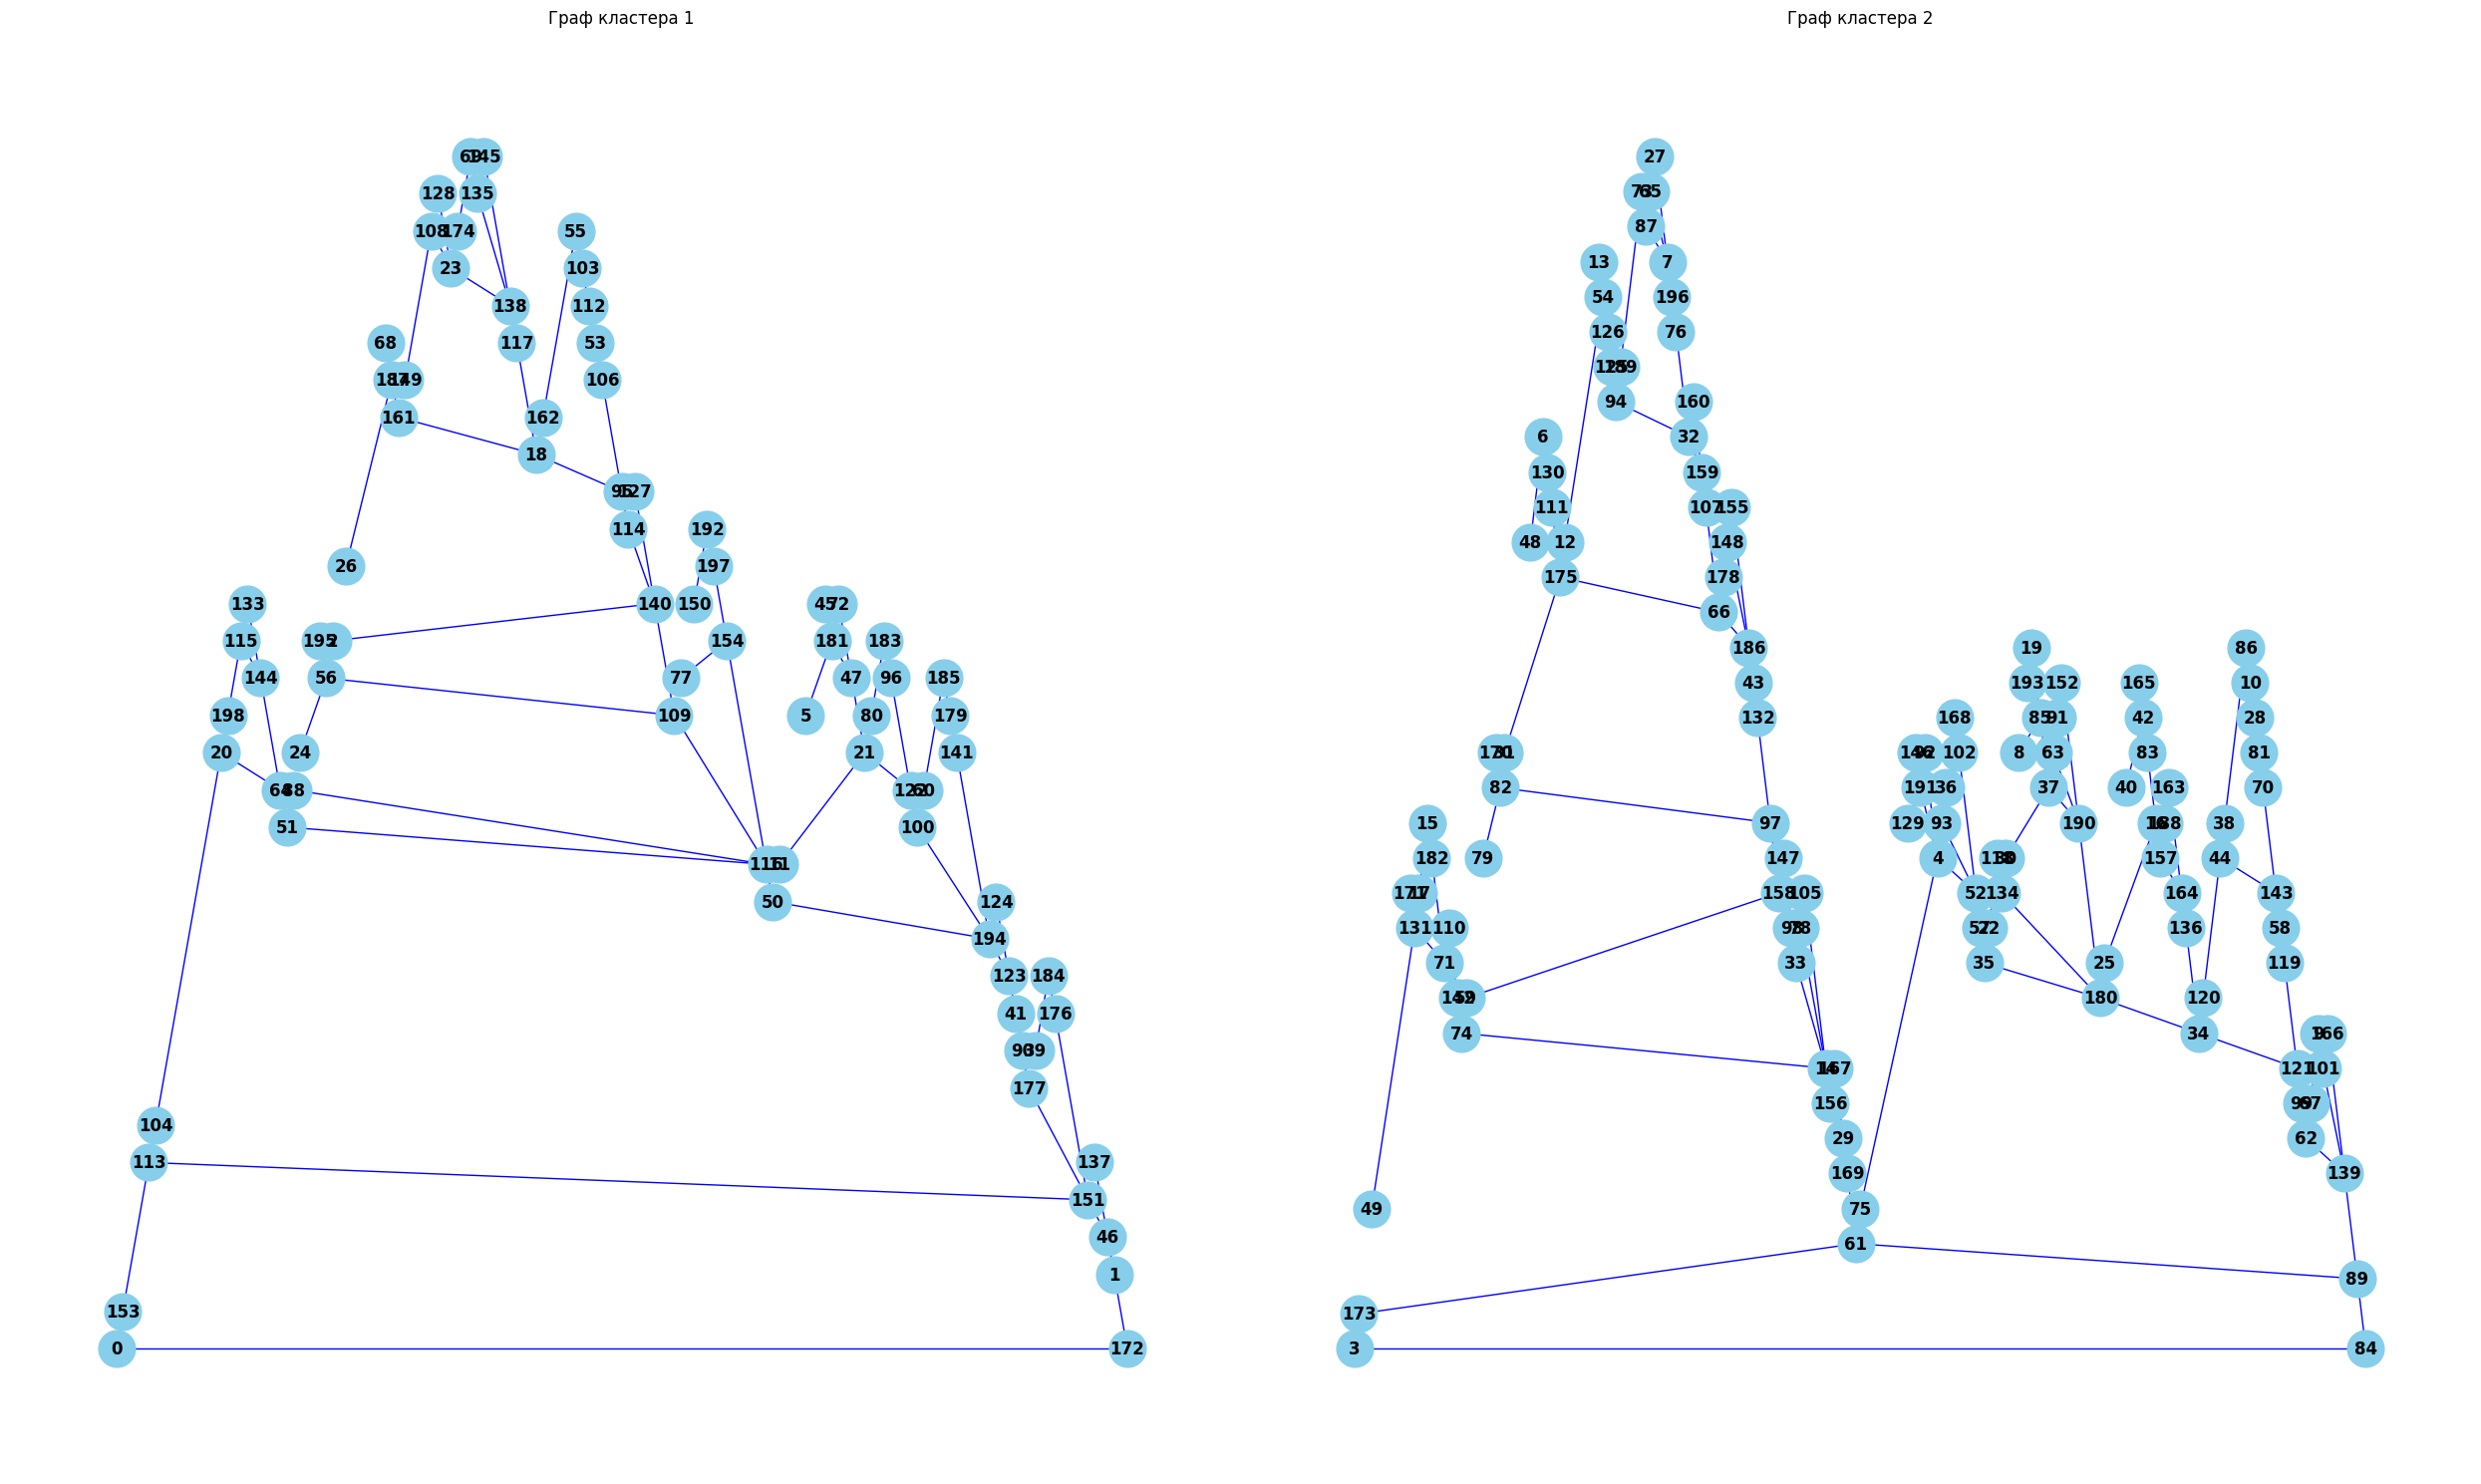

Кластер 1: [0, 1, 2, 5, 11, 18, 20, 21, 23, 24, 26, 39, 41, 45, 46, 47, 50, 51, 53, 55, 56, 60, 64, 68, 69, 72, 77, 80, 88, 90, 95, 96, 100, 103, 104, 106, 108, 109, 112, 113, 114, 115, 116, 117, 122, 123, 124, 127, 128, 133, 135, 137, 138, 140, 141, 144, 145, 149, 150, 151, 153, 154, 161, 162, 172, 174, 176, 177, 179, 181, 183, 184, 185, 187, 192, 194, 195, 197, 198]
Кластер 2: [3, 4, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 22, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 42, 43, 44, 48, 49, 52, 54, 57, 58, 59, 61, 62, 63, 65, 66, 67, 70, 71, 73, 74, 75, 76, 78, 79, 81, 82, 83, 84, 85, 86, 87, 89, 91, 92, 93, 94, 97, 98, 99, 101, 102, 105, 107, 110, 111, 118, 119, 120, 121, 125, 126, 129, 130, 131, 132, 134, 136, 139, 142, 143, 146, 147, 148, 152, 155, 156, 157, 158, 159, 160, 163, 164, 165, 166, 167, 168, 169, 170, 171, 173, 175, 178, 180, 182, 186, 188, 189, 190, 191, 193, 196]


In [134]:
G, clusters_mst = MST_clustering(2)

На визуализированных графах хорошо видно 3 отдельных сообщества, 2 из них были определены как один кластер, так как мы удалили только одно ребро из MST.

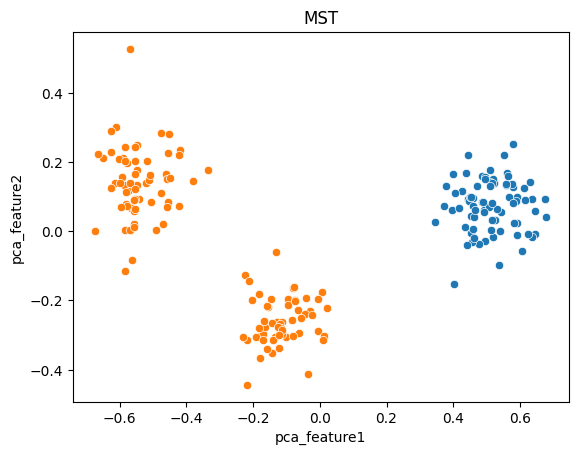

In [135]:
plt.title('MST')
plt.xlabel('pca_feature1')
plt.ylabel('pca_feature2')
for i in range(len(clusters_mst)):
    sns.scatterplot(x=data_2d[list(clusters_mst[i])][:, 0], y=data_2d[list(clusters_mst[i])][:, 1])

Двумерная карта хорошо согласуется с визуализированными графами выше

#### Кластеризация методом K-Means

Использовалась реализация из библиотеки sklearn

In [136]:

kmeans = KMeans(n_clusters=2, n_init=50)
kmeans.fit(Y)
labels_kmeans = kmeans.predict(Y)
cluster1 = np.arange(0, 199)[labels_kmeans == 1]
cluster2 = np.arange(0, 199)[labels_kmeans == 0]
clusters_kmeans = [set(cluster1), set(cluster2)]
for i, cluster in enumerate(clusters_kmeans, start=1):
    print(f"Кластер {i}: {sorted(list(map(lambda x: int(x), cluster)))}")

Кластер 1: [0, 1, 2, 5, 11, 18, 20, 21, 23, 24, 26, 39, 41, 45, 46, 47, 50, 51, 53, 55, 56, 60, 64, 68, 69, 72, 77, 80, 88, 90, 95, 96, 100, 103, 104, 106, 108, 109, 112, 113, 114, 115, 116, 117, 122, 123, 124, 127, 128, 133, 135, 137, 138, 140, 141, 144, 145, 149, 150, 151, 153, 154, 161, 162, 172, 174, 176, 177, 179, 181, 183, 184, 185, 187, 192, 194, 195, 197, 198]
Кластер 2: [3, 4, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 22, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 42, 43, 44, 48, 49, 52, 54, 57, 58, 59, 61, 62, 63, 65, 66, 67, 70, 71, 73, 74, 75, 76, 78, 79, 81, 82, 83, 84, 85, 86, 87, 89, 91, 92, 93, 94, 97, 98, 99, 101, 102, 105, 107, 110, 111, 118, 119, 120, 121, 125, 126, 129, 130, 131, 132, 134, 136, 139, 142, 143, 146, 147, 148, 152, 155, 156, 157, 158, 159, 160, 163, 164, 165, 166, 167, 168, 169, 170, 171, 173, 175, 178, 180, 182, 186, 188, 189, 190, 191, 193, 196]


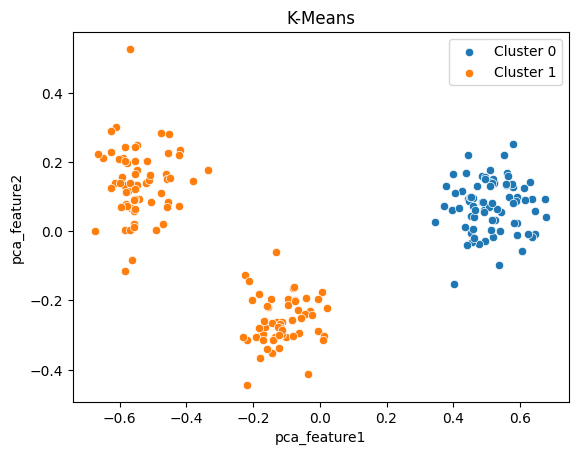

In [137]:
plt.title('K-Means')
plt.xlabel('pca_feature1')
plt.ylabel('pca_feature2')
for i in range(len(clusters_kmeans)):
    sns.scatterplot(x=data_2d[list(clusters_kmeans[i])][:, 0], y=data_2d[list(clusters_kmeans[i])][:, 1],
                    label=f'Cluster {i}')

Чтобы нарисовать центры, полученные алгоритмом, применим его к данным вложенным в двумерие

In [138]:
kmeans = KMeans(n_clusters=2, n_init=50)
kmeans.fit(data_2d)
labels = kmeans.predict(data_2d)
cluster1 = np.arange(0, 199)[labels == 1]
cluster2 = np.arange(0, 199)[labels == 0]
clusters_kmeans = [set(cluster1), set(cluster2)]
for i, cluster in enumerate(clusters_kmeans, start=1):
    print(f"Кластер {i}: {sorted(list(map(lambda x: int(x), cluster)))}")

Кластер 1: [0, 1, 2, 5, 11, 18, 20, 21, 23, 24, 26, 39, 41, 45, 46, 47, 50, 51, 53, 55, 56, 60, 64, 68, 69, 72, 77, 80, 88, 90, 95, 96, 100, 103, 104, 106, 108, 109, 112, 113, 114, 115, 116, 117, 122, 123, 124, 127, 128, 133, 135, 137, 138, 140, 141, 144, 145, 149, 150, 151, 153, 154, 161, 162, 172, 174, 176, 177, 179, 181, 183, 184, 185, 187, 192, 194, 195, 197, 198]
Кластер 2: [3, 4, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 22, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 42, 43, 44, 48, 49, 52, 54, 57, 58, 59, 61, 62, 63, 65, 66, 67, 70, 71, 73, 74, 75, 76, 78, 79, 81, 82, 83, 84, 85, 86, 87, 89, 91, 92, 93, 94, 97, 98, 99, 101, 102, 105, 107, 110, 111, 118, 119, 120, 121, 125, 126, 129, 130, 131, 132, 134, 136, 139, 142, 143, 146, 147, 148, 152, 155, 156, 157, 158, 159, 160, 163, 164, 165, 166, 167, 168, 169, 170, 171, 173, 175, 178, 180, 182, 186, 188, 189, 190, 191, 193, 196]


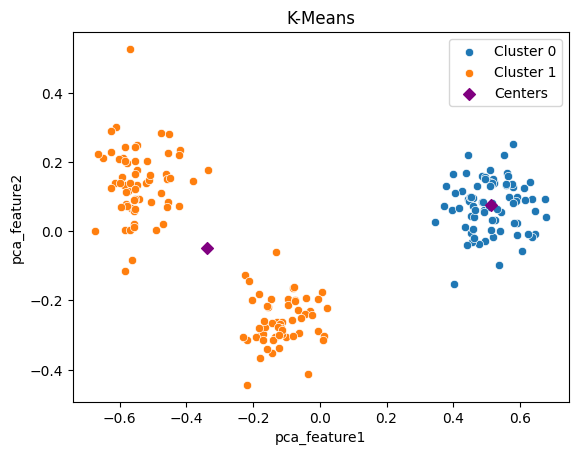

In [139]:
centroids = kmeans.cluster_centers_

plt.title('K-Means')
plt.xlabel('pca_feature1')
plt.ylabel('pca_feature2')
for i in range(len(clusters_kmeans)):
    sns.scatterplot(x=data_2d[list(clusters_kmeans[i])][:, 0], y=data_2d[list(clusters_kmeans[i])][:, 1],
                    label=f'Cluster {i}')
    
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            marker='D', label='Centers', color='purple')
plt.legend(loc='upper right')

#### Кластеризация EM-алгоритмом

Использовалась реализация этого алгоритма из библиотеки sklearn

In [140]:
gmm = GaussianMixture(n_components=2, covariance_type="full", random_state=54)
gmm.fit(Y)
labels_em = gmm.predict(Y)
cluster1 = np.arange(0, 199)[labels_em == 1]
cluster2 = np.arange(0, 199)[labels_em == 0]
clusters_em = [set(cluster1), set(cluster2)]
for i, cluster in enumerate(clusters_em, start=1):
    print(f"Кластер {i}: {sorted(list(map(lambda x: int(x), cluster)))}")

Кластер 1: [0, 1, 2, 5, 11, 18, 20, 21, 23, 24, 26, 39, 41, 45, 46, 47, 50, 51, 53, 55, 56, 60, 64, 68, 69, 72, 77, 80, 88, 90, 95, 96, 100, 103, 104, 106, 108, 109, 112, 113, 114, 115, 116, 117, 122, 123, 124, 127, 128, 133, 135, 137, 138, 140, 141, 144, 145, 149, 150, 151, 153, 154, 161, 162, 172, 174, 176, 177, 179, 181, 183, 184, 185, 187, 192, 194, 195, 197, 198]
Кластер 2: [3, 4, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 22, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 42, 43, 44, 48, 49, 52, 54, 57, 58, 59, 61, 62, 63, 65, 66, 67, 70, 71, 73, 74, 75, 76, 78, 79, 81, 82, 83, 84, 85, 86, 87, 89, 91, 92, 93, 94, 97, 98, 99, 101, 102, 105, 107, 110, 111, 118, 119, 120, 121, 125, 126, 129, 130, 131, 132, 134, 136, 139, 142, 143, 146, 147, 148, 152, 155, 156, 157, 158, 159, 160, 163, 164, 165, 166, 167, 168, 169, 170, 171, 173, 175, 178, 180, 182, 186, 188, 189, 190, 191, 193, 196]


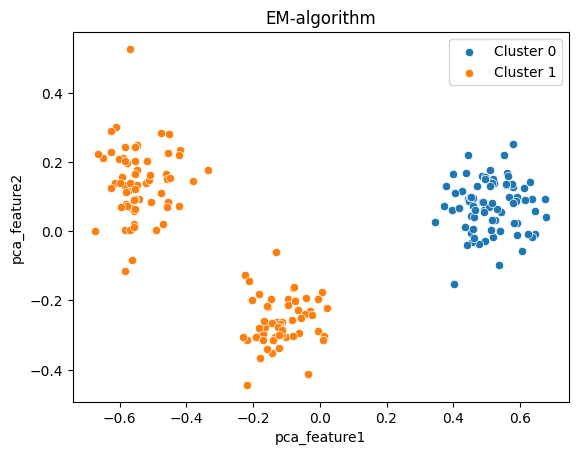

In [141]:
plt.title('EM-algorithm')
plt.xlabel('pca_feature1')
plt.ylabel('pca_feature2')
for i in range(len(clusters_em)):
    sns.scatterplot(x=data_2d[list(clusters_em[i])][:, 0], y=data_2d[list(clusters_em[i])][:, 1],
                    label=f'Cluster {i}')

Кластеризация EM-алгоритмом на двумерных данных для визуализации результатов

In [142]:
gmm = GaussianMixture(n_components=2, covariance_type="full", random_state=54)
gmm.fit(data_2d)
labels = gmm.predict(data_2d)
cluster1 = np.arange(0, 199)[labels == 1]
cluster2 = np.arange(0, 199)[labels == 0]
clusters_em = [set(cluster1), set(cluster2)]
for i, cluster in enumerate(clusters_em, start=1):
    print(f"Кластер {i}: {sorted(list(map(lambda x: int(x), cluster)))}")

Кластер 1: [0, 1, 2, 5, 11, 18, 20, 21, 23, 24, 26, 39, 41, 45, 46, 47, 50, 51, 53, 55, 56, 60, 64, 68, 69, 72, 77, 80, 88, 90, 95, 96, 100, 103, 104, 106, 108, 109, 112, 113, 114, 115, 116, 117, 122, 123, 124, 127, 128, 133, 135, 137, 138, 140, 141, 144, 145, 149, 150, 151, 153, 154, 161, 162, 172, 174, 176, 177, 179, 181, 183, 184, 185, 187, 192, 194, 195, 197, 198]
Кластер 2: [3, 4, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 22, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 42, 43, 44, 48, 49, 52, 54, 57, 58, 59, 61, 62, 63, 65, 66, 67, 70, 71, 73, 74, 75, 76, 78, 79, 81, 82, 83, 84, 85, 86, 87, 89, 91, 92, 93, 94, 97, 98, 99, 101, 102, 105, 107, 110, 111, 118, 119, 120, 121, 125, 126, 129, 130, 131, 132, 134, 136, 139, 142, 143, 146, 147, 148, 152, 155, 156, 157, 158, 159, 160, 163, 164, 165, 166, 167, 168, 169, 170, 171, 173, 175, 178, 180, 182, 186, 188, 189, 190, 191, 193, 196]


/tmp/ipykernel_10698/486443029.py:8: UserWarning: Log scale: values of z <= 0 have been masked
  CS = plt.contour(


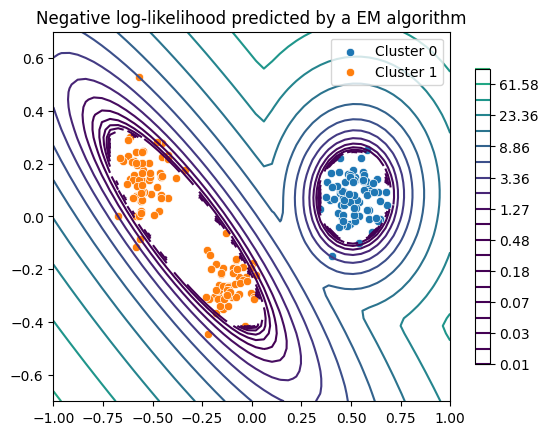

In [143]:
x = np.linspace(-1, 1)
y = np.linspace(-0.7, 0.7)
X_, Y_ = np.meshgrid(x, y)
XX = np.array([X_.ravel(), Y_.ravel()]).T
Z = -gmm.score_samples(XX)
Z = Z.reshape(X_.shape)

CS = plt.contour(
    X_, Y_, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(-2, 2, 20)
)
CB = plt.colorbar(CS, shrink=0.8, extend="both")
# plt.scatter(data_2d[:, 0], data_2d[:, 1], 0.8)
for i in range(len(clusters_em)):
    sns.scatterplot(x=data_2d[list(clusters_em[i])][:, 0], y=data_2d[list(clusters_em[i])][:, 1],
                    label=f'Cluster {i}')

plt.title("Negative log-likelihood predicted by a EM algorithm")
plt.axis("tight")
plt.show()

#### Кластеризация Unnormalized Spectral методом

In [144]:
W = sim_matrix
D = np.diag([W.shape[0] for _ in range(W.shape[0])])
L = D - W

In [145]:
eig_vals, eig_vecs = np.linalg.eigh(L)
eig_vecs_2 = eig_vecs[:, :2]
kmeans = KMeans(n_clusters=2, n_init=50)
labels_spectral = kmeans.fit_predict(eig_vecs_2)
cluster1 = np.arange(0, 199)[labels_spectral == 1]
cluster2 = np.arange(0, 199)[labels_spectral == 0]
clusters_spectral = [set(cluster1), set(cluster2)]
for i, cluster in enumerate(clusters_spectral, start=1):
    print(f"Кластер {i}: {sorted(list(map(lambda x: int(x), cluster)))}")

Кластер 1: [0, 1, 2, 5, 11, 18, 20, 21, 23, 24, 26, 39, 41, 45, 46, 47, 50, 51, 53, 55, 56, 60, 64, 68, 69, 72, 77, 80, 88, 90, 95, 96, 100, 103, 104, 106, 108, 109, 112, 113, 114, 115, 116, 117, 122, 123, 124, 127, 128, 133, 135, 137, 138, 140, 141, 144, 145, 149, 150, 151, 153, 154, 161, 162, 172, 174, 176, 177, 179, 181, 183, 184, 185, 187, 192, 194, 195, 197, 198]
Кластер 2: [3, 4, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 22, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 42, 43, 44, 48, 49, 52, 54, 57, 58, 59, 61, 62, 63, 65, 66, 67, 70, 71, 73, 74, 75, 76, 78, 79, 81, 82, 83, 84, 85, 86, 87, 89, 91, 92, 93, 94, 97, 98, 99, 101, 102, 105, 107, 110, 111, 118, 119, 120, 121, 125, 126, 129, 130, 131, 132, 134, 136, 139, 142, 143, 146, 147, 148, 152, 155, 156, 157, 158, 159, 160, 163, 164, 165, 166, 167, 168, 169, 170, 171, 173, 175, 178, 180, 182, 186, 188, 189, 190, 191, 193, 196]


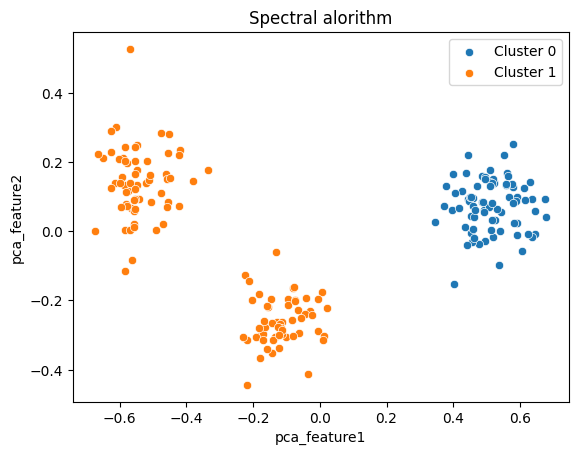

In [146]:
plt.title('Spectral alorithm')
plt.xlabel('pca_feature1')
plt.ylabel('pca_feature2')
for i in range(len(clusters_spectral)):
    sns.scatterplot(x=data_2d[list(clusters_spectral[i])][:, 0], y=data_2d[list(clusters_spectral[i])][:, 1],
                    label=f'Cluster {i}')

#### Подсчет RAND индекса

Сравнение разбиений попарно

In [147]:
def count_pairs_disjoin(left_set: set, right_sets: list):
    left_set_pairs_cnt = len(left_set) * (len(left_set) - 1)

    for rs in right_sets:
        separation = left_set.intersection(rs)
        left_set_pairs_cnt = left_set_pairs_cnt - len(separation) * (
            len(separation) - 1
        )

    return left_set_pairs_cnt


def count_pairs_join(left_set: set, right_sets: list):
    left_set_pairs_cnt = 0

    for rs in right_sets:
        separation = left_set.intersection(rs)
        left_set_pairs_cnt = left_set_pairs_cnt + len(separation) * (
            len(separation) - 1
        )

    return left_set_pairs_cnt


def get_rand_index(part1: list, part2: list):
    left_sets = part1
    right_sets = part2

    left_pair_union = sum([count_pairs_join(x, right_sets) for x in left_sets])
    right_pair_union = sum([count_pairs_join(x, left_sets) for x in right_sets])

    union_cnt = left_pair_union + right_pair_union

    left_pair_diff = sum([count_pairs_disjoin(x, right_sets) for x in left_sets])
    right_pair_diff = sum([count_pairs_disjoin(x, left_sets) for x in right_sets])

    diff_cnt = left_pair_diff + right_pair_diff

    return union_cnt / (union_cnt + diff_cnt)

In [148]:
def r_partition(n_parts, edges):
    idxs = list(range(0, edges))
    random.shuffle(idxs)
    return [set(idxs[i::n_parts]) for i in range(n_parts)]

In [149]:
rand_idx_matrix = np.zeros((5, 5))

for i, m1 in enumerate([clusters_mst, clusters_kmeans, clusters_em, clusters_spectral]):
    for j, m2 in enumerate(
        [clusters_mst, clusters_kmeans, clusters_em, clusters_spectral]
    ):
        rand_idx_matrix[i, j] = get_rand_index(m1, m2)

rand_idx_matrix

array([[1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0.]])

In [150]:
random_partitions = [r_partition(2, 199) for i in range(100)]

In [151]:
for i, m in enumerate([clusters_mst, clusters_kmeans, clusters_em, clusters_spectral]):
    mean_rand_idx_vs_randompart = (
        sum([get_rand_index(m, r) for r in random_partitions]) / 100
    )
    rand_idx_matrix[i, 4] = rand_idx_matrix[4, i] = mean_rand_idx_vs_randompart

In [152]:
rand_idx_matrix[4, 4] = sum([sum([get_rand_index(r1, r2) for r1 in random_partitions]) for r2 in random_partitions]) / 100**2

In [153]:
rand_idx_matrix

array([[1.       , 1.       , 1.       , 1.       , 0.5076366],
       [1.       , 1.       , 1.       , 1.       , 0.5076366],
       [1.       , 1.       , 1.       , 1.       , 0.5076366],
       [1.       , 1.       , 1.       , 1.       , 0.5076366],
       [0.5076366, 0.5076366, 0.5076366, 0.5076366, 0.5024865]])

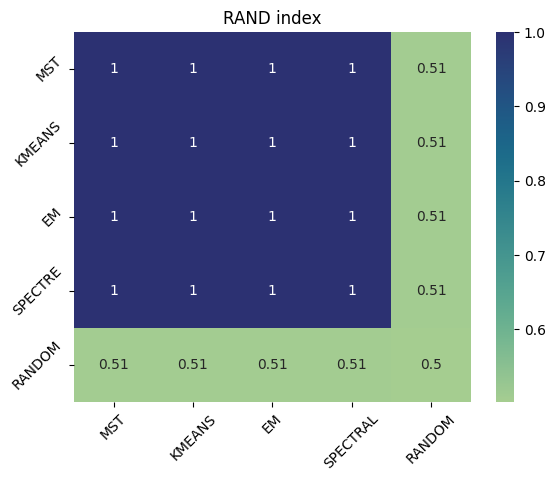

In [154]:
plt.title("RAND index")
g = sns.heatmap(
    rand_idx_matrix,
    annot=True,
    xticklabels=["MST", "KMEANS", "EM", "SPECTRAL", "RANDOM"],
    yticklabels=["MST", "KMEANS", "EM", "SPECTRE", "RANDOM"],
    cmap="crest",
)
if g.get_yticklabels():
    g.set_yticklabels(labels=g.get_yticklabels(), rotation=45)
if g.get_xticklabels():
    g.set_xticklabels(g.get_xticklabels(), rotation=45)

Значения RAND индексов говорят о том, что все алгоритмы получают одинаковые разбиения, что также подтверждается двумерными картами полученных разбиений.

Под рандомным алгоритмом здесь имеется в виду следующее:
1) Было сделано 100 случайных разбиений графа
2) Для каждого такого разбиения считался RAND индекс с каждым разбиением, полученным другим методом, после чего значения были усреднены.
3) Чтобы получить RAND индекс пары (случайный алгоритм, случайный алгоритм), были посчитаны RAND индексы между всеми случайными разбиениями и затем усреднены.

In [155]:
mfn_rand = []

for k in range(0, 100):
    rpart = r_partition(2, 199)
    mfn_rand.append(nx.community.modularity(G, rpart))

In [156]:
for part, part_name in zip(
    [clusters_mst, clusters_kmeans, clusters_em, clusters_spectral],
    ["MST", "KMEANS", "EM", "SPECTRAL"],
):
    print(f"{part_name} clustering modularity value:", nx.community.modularity(G, part))
print("RANDOM clustering modularity value:", sum(mfn_rand) / 100)

MST clustering modularity value: 0.08223448016003868
KMEANS clustering modularity value: 0.08223448016003868
EM clustering modularity value: 0.08223448016003868
SPECTRAL clustering modularity value: 0.08223448016003868
RANDOM clustering modularity value: -0.0024388636695565715


Значения модулярности для разбиений, полученных вышеописанными алгоритмами получились довольно маленькими, но все же относительно сильно больше, чем для случайных разбиений.

Значения функции модулярности получились одинаковыми для всех алгоритмов, что вполне ожидаемо.

In [157]:
def get_labels_from_clusters(clusters):
    labels = np.zeros(sum([len(c) for c in clusters]), dtype=int)
    for i, cluster in enumerate(clusters):
        labels[list(cluster)] = i
    return labels

In [158]:
sil_rand = []

for k in range(0, 100):
    rpart = r_partition(2, 199)
    sil_rand.append(silhouette_score(Y, get_labels_from_clusters(rpart)))

Подсчет Silhouette Score

Silhouette score отражает близость каждого наблюдения к точкам из своего кластера и других кластеров. Данная метрика задается следующим образом:

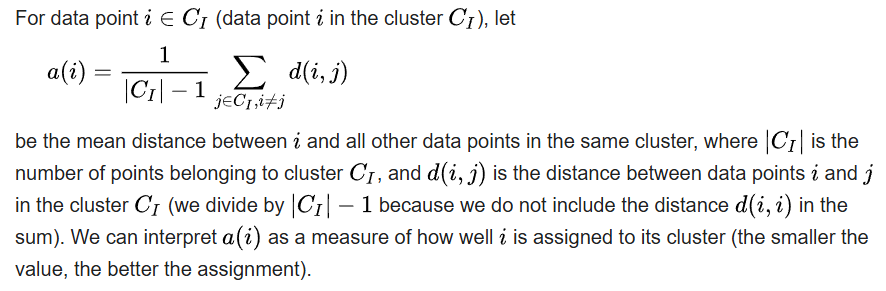
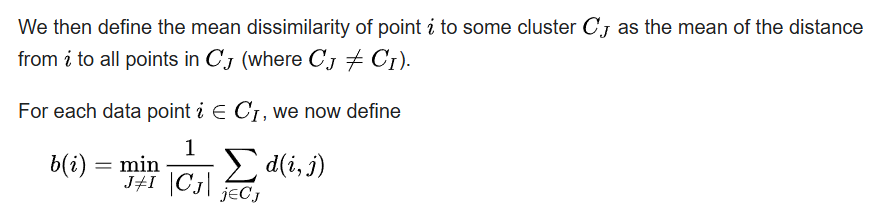
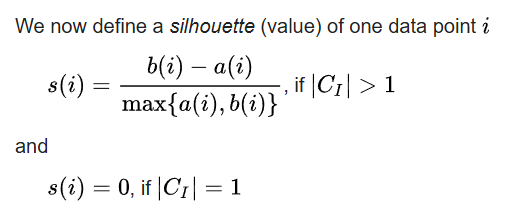

In [159]:
for part, part_name in zip(
    [clusters_mst, clusters_kmeans, clusters_em, clusters_spectral],
    ["MST", "KMEANS", "EM", "SPECTRAL"],
):
    cur_labels = get_labels_from_clusters(part)
    print(f'{part_name} silhouette score: {silhouette_score(Y, cur_labels)}')
    
print("RANDOM silhouette score:", sum(sil_rand) / 100)

MST silhouette score: 0.5872170482007042
KMEANS silhouette score: 0.5872170482007042
EM silhouette score: 0.5872170482007042
SPECTRAL silhouette score: 0.5872170482007042
RANDOM silhouette score: 0.0004342800539554368


Значения Silhouette получились также одинаковыми.

Важнее то, что они получились очень даже неплохими, что говорит о том, что элементы кластеров действительно похожи на своих соседей по кластеру больше, чем на элементы из других кластеров. И все-таки метрика не так близка к единице, можно предположить, что если разбить эти данные на 3 кластера, то значение Silhouette будет ближе к единице.

## Кластеризация для числа кластеров k=3

#### Кластеризация методом MST

<Figure size 800x600 with 0 Axes>

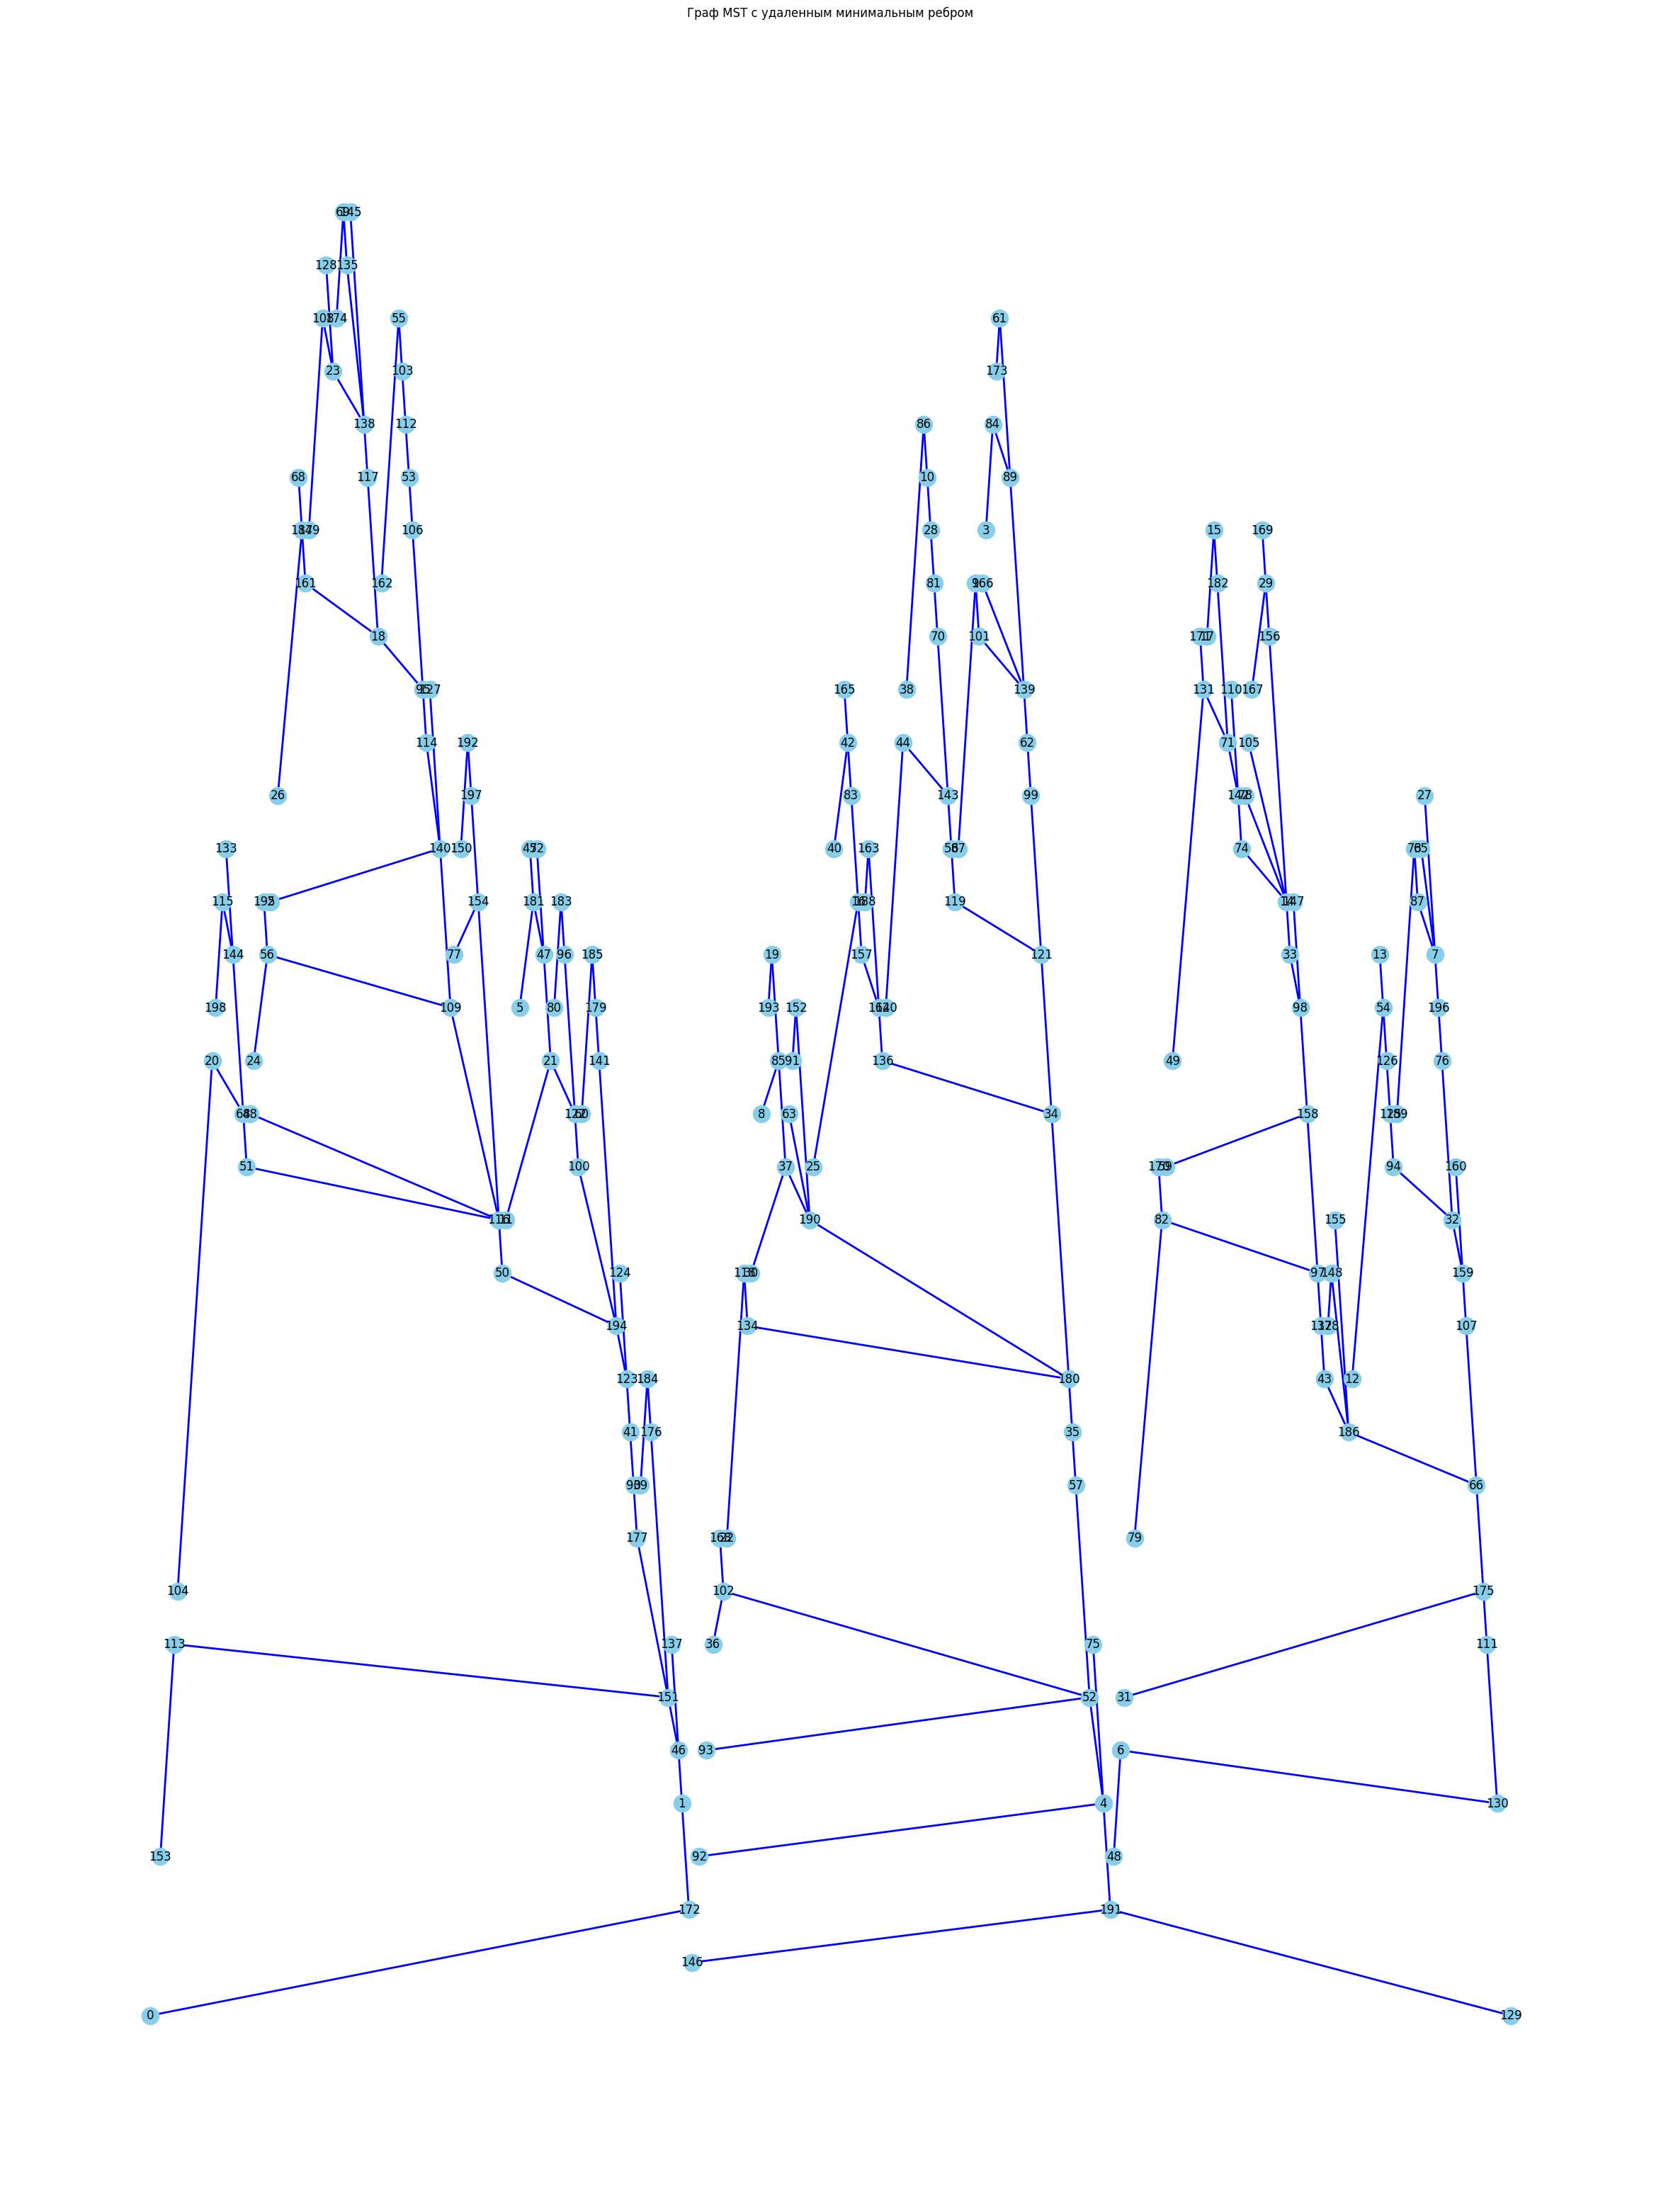

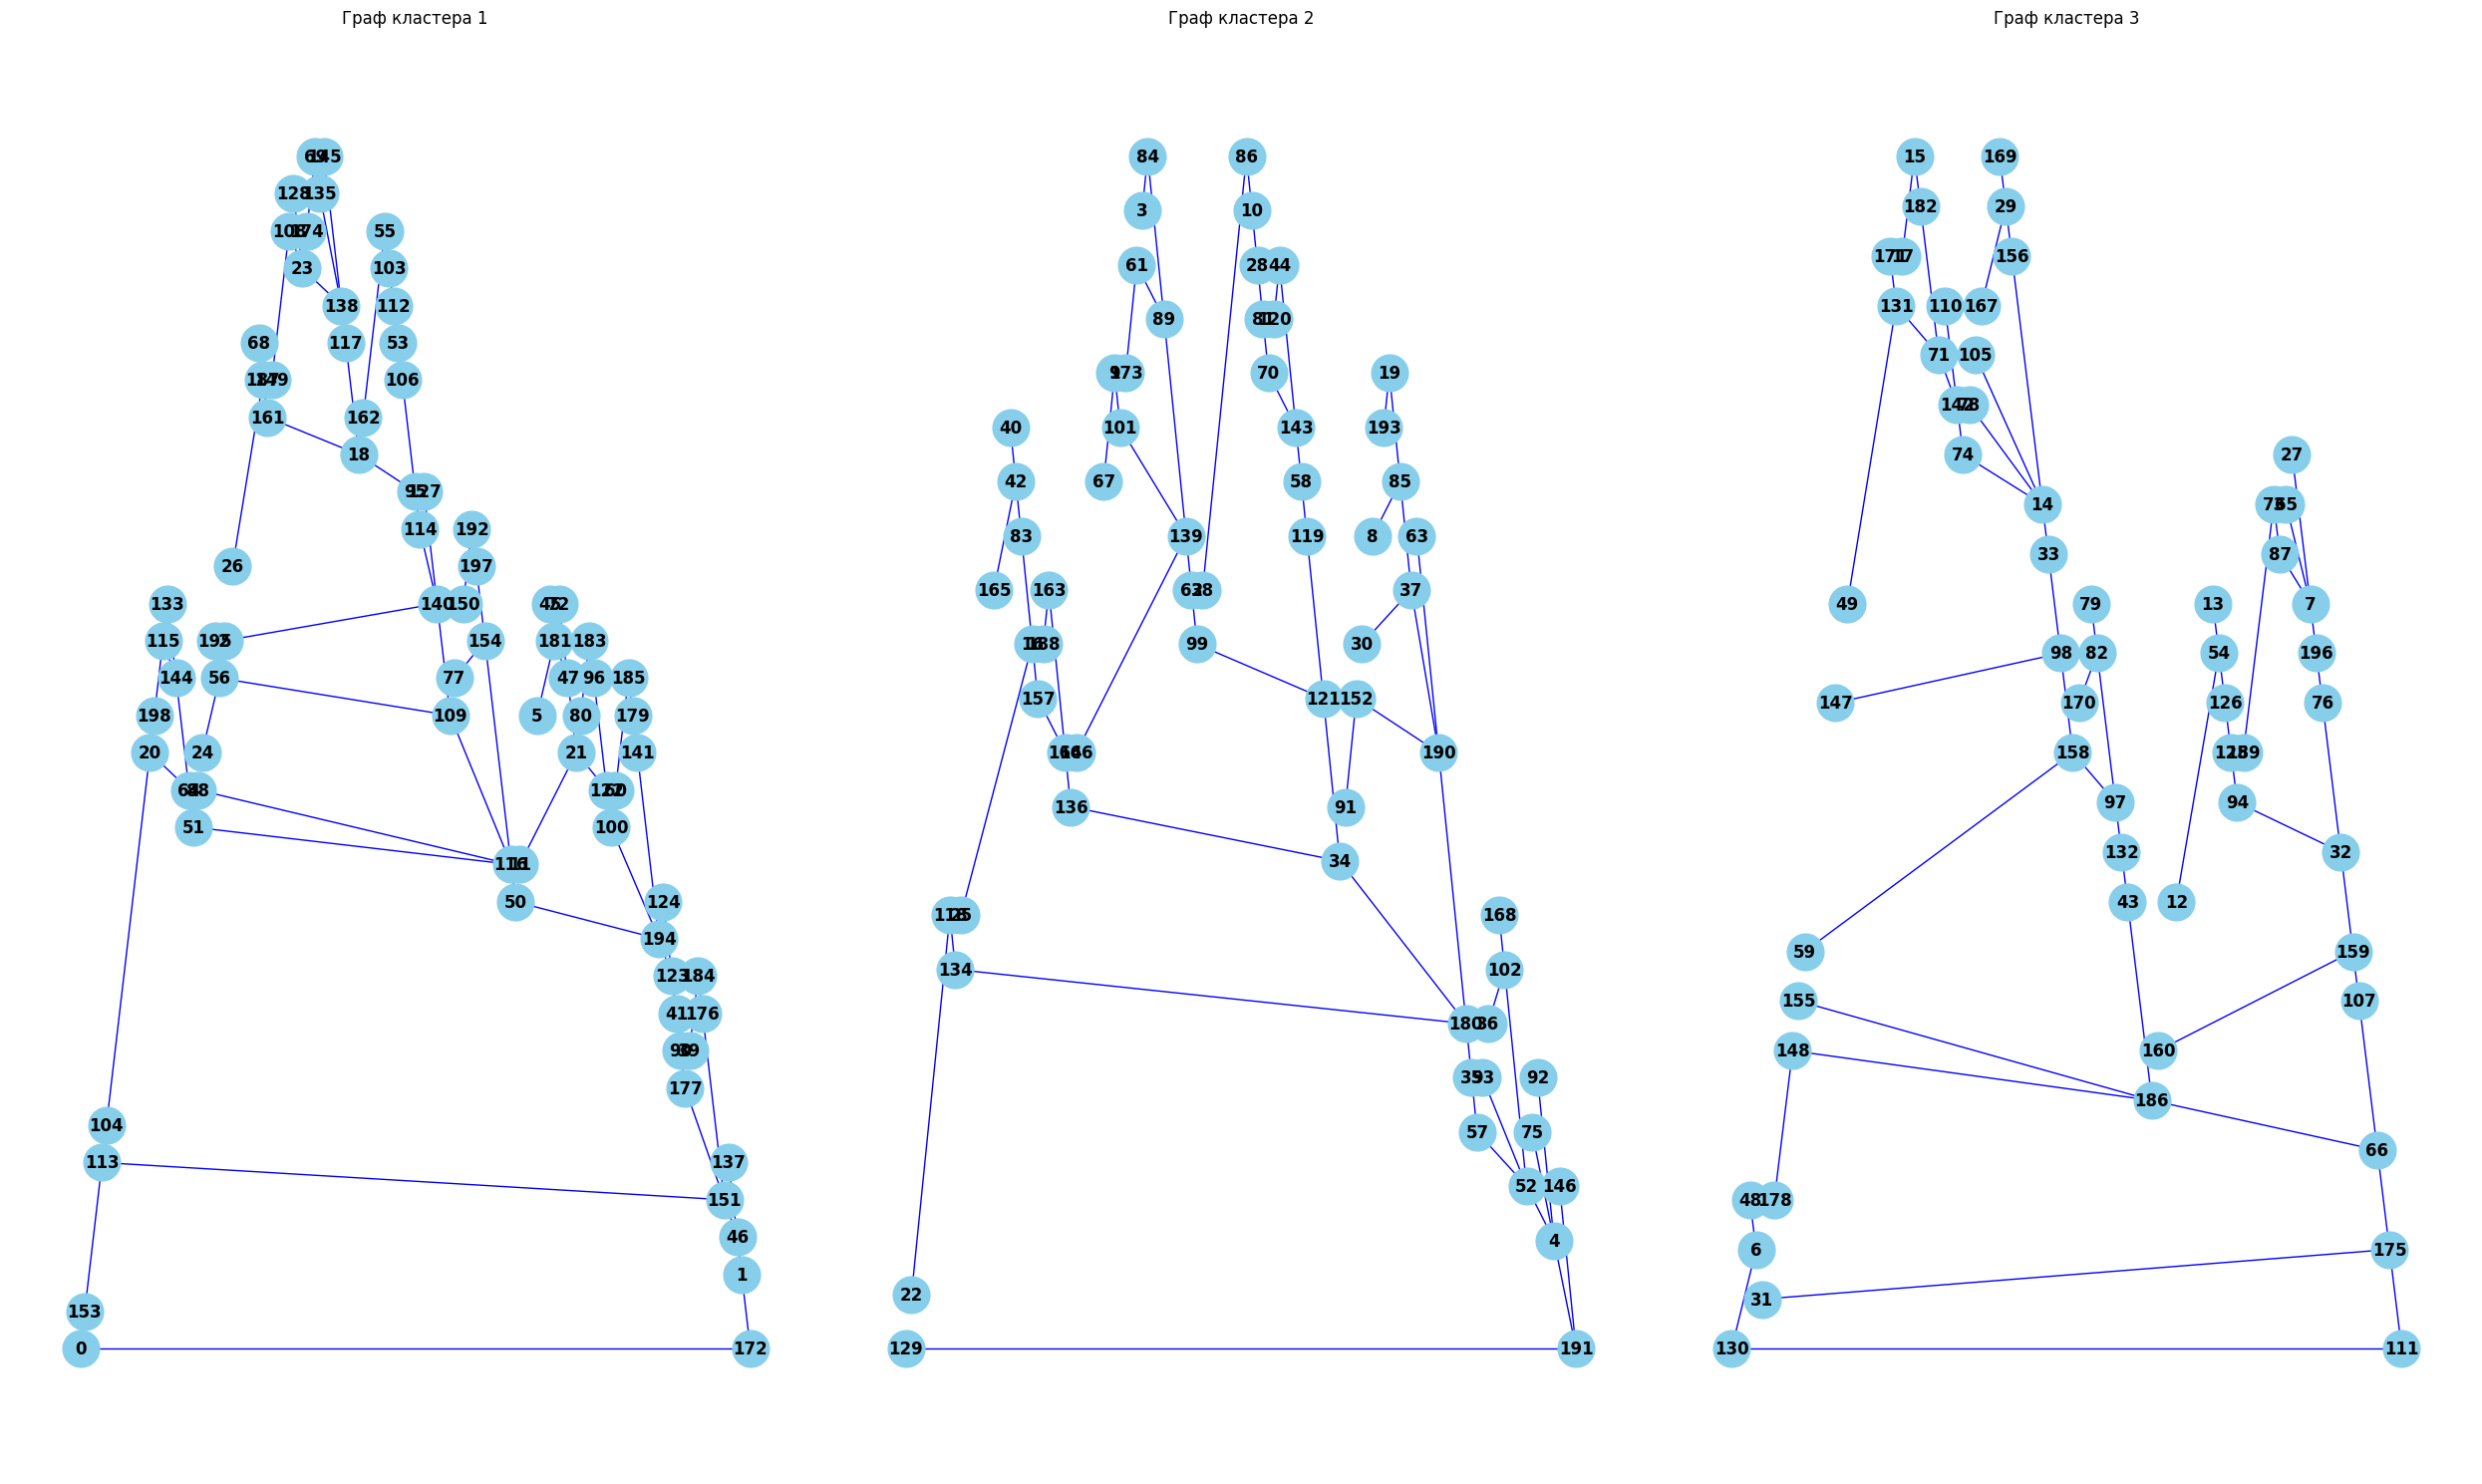

Кластер 1: [0, 1, 2, 5, 11, 18, 20, 21, 23, 24, 26, 39, 41, 45, 46, 47, 50, 51, 53, 55, 56, 60, 64, 68, 69, 72, 77, 80, 88, 90, 95, 96, 100, 103, 104, 106, 108, 109, 112, 113, 114, 115, 116, 117, 122, 123, 124, 127, 128, 133, 135, 137, 138, 140, 141, 144, 145, 149, 150, 151, 153, 154, 161, 162, 172, 174, 176, 177, 179, 181, 183, 184, 185, 187, 192, 194, 195, 197, 198]
Кластер 2: [3, 4, 8, 9, 10, 16, 19, 22, 25, 28, 30, 34, 35, 36, 37, 38, 40, 42, 44, 52, 57, 58, 61, 62, 63, 67, 70, 75, 81, 83, 84, 85, 86, 89, 91, 92, 93, 99, 101, 102, 118, 119, 120, 121, 129, 134, 136, 139, 143, 146, 152, 157, 163, 164, 165, 166, 168, 173, 180, 188, 190, 191, 193]
Кластер 3: [6, 7, 12, 13, 14, 15, 17, 27, 29, 31, 32, 33, 43, 48, 49, 54, 59, 65, 66, 71, 73, 74, 76, 78, 79, 82, 87, 94, 97, 98, 105, 107, 110, 111, 125, 126, 130, 131, 132, 142, 147, 148, 155, 156, 158, 159, 160, 167, 169, 170, 171, 175, 178, 182, 186, 189, 196]


In [160]:
G, clusters_mst = MST_clustering(3)

На визуализированных графах хорошо видно 3 отдельных сообщества.

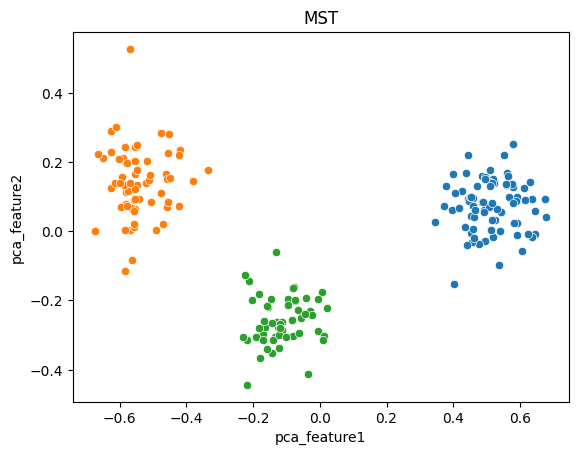

In [161]:
plt.title('MST')
plt.xlabel('pca_feature1')
plt.ylabel('pca_feature2')
for i in range(len(clusters_mst)):
    sns.scatterplot(x=data_2d[list(clusters_mst[i])][:, 0], y=data_2d[list(clusters_mst[i])][:, 1])

Двумерная карта показывает, что MST хорошо кластеризовал наблюдения

#### Кластеризация методом K-Means

In [162]:
kmeans = KMeans(n_clusters=3, n_init=50)
kmeans.fit(Y)
labels_kmeans = kmeans.predict(Y)
clusters_kmeans = []
for i in range(3):
    cluster =  np.arange(0, 199)[labels_kmeans == i]
    clusters_kmeans.append(set(cluster))
for i, cluster in enumerate(clusters_kmeans, start=1):
    print(f"Кластер {i}: {sorted(list(map(lambda x: int(x), cluster)))}")

Кластер 1: [0, 1, 2, 5, 11, 18, 20, 21, 23, 24, 26, 39, 41, 45, 46, 47, 50, 51, 53, 55, 56, 60, 64, 68, 69, 72, 77, 80, 88, 90, 95, 96, 100, 103, 104, 106, 108, 109, 112, 113, 114, 115, 116, 117, 122, 123, 124, 127, 128, 133, 135, 137, 138, 140, 141, 144, 145, 149, 150, 151, 153, 154, 161, 162, 172, 174, 176, 177, 179, 181, 183, 184, 185, 187, 192, 194, 195, 197, 198]
Кластер 2: [3, 4, 8, 9, 10, 16, 19, 22, 25, 28, 30, 34, 35, 36, 37, 38, 40, 42, 44, 52, 57, 58, 61, 62, 63, 67, 70, 75, 81, 83, 84, 85, 86, 89, 91, 92, 93, 99, 101, 102, 118, 119, 120, 121, 129, 134, 136, 139, 143, 146, 152, 157, 163, 164, 165, 166, 168, 173, 180, 188, 190, 191, 193]
Кластер 3: [6, 7, 12, 13, 14, 15, 17, 27, 29, 31, 32, 33, 43, 48, 49, 54, 59, 65, 66, 71, 73, 74, 76, 78, 79, 82, 87, 94, 97, 98, 105, 107, 110, 111, 125, 126, 130, 131, 132, 142, 147, 148, 155, 156, 158, 159, 160, 167, 169, 170, 171, 175, 178, 182, 186, 189, 196]


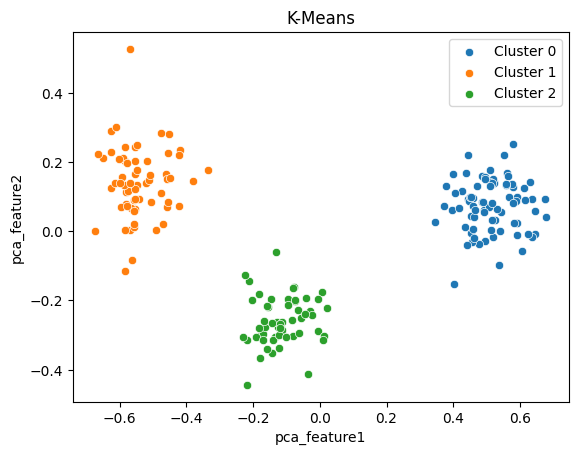

In [163]:
plt.title('K-Means')
plt.xlabel('pca_feature1')
plt.ylabel('pca_feature2')
for i in range(len(clusters_kmeans)):
    sns.scatterplot(x=data_2d[list(clusters_kmeans[i])][:, 0], y=data_2d[list(clusters_kmeans[i])][:, 1],
                    label=f'Cluster {i}')

Чтобы нарисовать центры, полученные алгоритмом, применим его к данным вложенным в двумерие

In [164]:
kmeans = KMeans(n_clusters=3, n_init=50)
kmeans.fit(data_2d)
labels = kmeans.predict(data_2d)
clusters_kmeans = []
for i in range(3):
    cluster =  np.arange(0, 199)[labels_kmeans == i]
    clusters_kmeans.append(set(cluster))
for i, cluster in enumerate(clusters_kmeans, start=1):
    print(f"Кластер {i}: {sorted(list(map(lambda x: int(x), cluster)))}")

Кластер 1: [0, 1, 2, 5, 11, 18, 20, 21, 23, 24, 26, 39, 41, 45, 46, 47, 50, 51, 53, 55, 56, 60, 64, 68, 69, 72, 77, 80, 88, 90, 95, 96, 100, 103, 104, 106, 108, 109, 112, 113, 114, 115, 116, 117, 122, 123, 124, 127, 128, 133, 135, 137, 138, 140, 141, 144, 145, 149, 150, 151, 153, 154, 161, 162, 172, 174, 176, 177, 179, 181, 183, 184, 185, 187, 192, 194, 195, 197, 198]
Кластер 2: [3, 4, 8, 9, 10, 16, 19, 22, 25, 28, 30, 34, 35, 36, 37, 38, 40, 42, 44, 52, 57, 58, 61, 62, 63, 67, 70, 75, 81, 83, 84, 85, 86, 89, 91, 92, 93, 99, 101, 102, 118, 119, 120, 121, 129, 134, 136, 139, 143, 146, 152, 157, 163, 164, 165, 166, 168, 173, 180, 188, 190, 191, 193]
Кластер 3: [6, 7, 12, 13, 14, 15, 17, 27, 29, 31, 32, 33, 43, 48, 49, 54, 59, 65, 66, 71, 73, 74, 76, 78, 79, 82, 87, 94, 97, 98, 105, 107, 110, 111, 125, 126, 130, 131, 132, 142, 147, 148, 155, 156, 158, 159, 160, 167, 169, 170, 171, 175, 178, 182, 186, 189, 196]


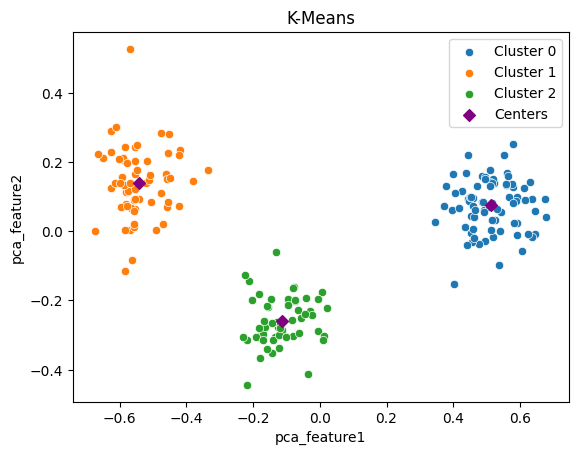

In [165]:
centroids = kmeans.cluster_centers_

plt.title('K-Means')
plt.xlabel('pca_feature1')
plt.ylabel('pca_feature2')
for i in range(len(clusters_kmeans)):
    sns.scatterplot(x=data_2d[list(clusters_kmeans[i])][:, 0], y=data_2d[list(clusters_kmeans[i])][:, 1],
                    label=f'Cluster {i}')
    
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            marker='D', label='Centers', color='purple')
plt.legend(loc='upper right')

#### Кластеризация EM-алгоритмом

In [166]:
gmm = GaussianMixture(n_components=3, covariance_type="full", random_state=54)
gmm.fit(Y)
labels_em = gmm.predict(Y)
clusters_em = []
for i in range(3):
    cluster =  np.arange(0, 199)[labels_em == i]
    clusters_em.append(set(cluster))
for i, cluster in enumerate(clusters_em, start=1):
    print(f"Кластер {i}: {sorted(list(map(lambda x: int(x), cluster)))}")

Кластер 1: [6, 7, 12, 13, 14, 15, 17, 27, 29, 31, 32, 33, 43, 48, 49, 54, 59, 65, 66, 71, 73, 74, 76, 78, 79, 82, 87, 94, 97, 98, 105, 107, 110, 111, 125, 126, 130, 131, 132, 142, 147, 148, 155, 156, 158, 159, 160, 167, 169, 170, 171, 175, 178, 182, 186, 189, 196]
Кластер 2: [0, 1, 2, 5, 11, 18, 20, 21, 23, 24, 26, 39, 41, 45, 46, 47, 50, 51, 53, 55, 56, 60, 64, 68, 69, 72, 77, 80, 88, 90, 95, 96, 100, 103, 104, 106, 108, 109, 112, 113, 114, 115, 116, 117, 122, 123, 124, 127, 128, 133, 135, 137, 138, 140, 141, 144, 145, 149, 150, 151, 153, 154, 161, 162, 172, 174, 176, 177, 179, 181, 183, 184, 185, 187, 192, 194, 195, 197, 198]
Кластер 3: [3, 4, 8, 9, 10, 16, 19, 22, 25, 28, 30, 34, 35, 36, 37, 38, 40, 42, 44, 52, 57, 58, 61, 62, 63, 67, 70, 75, 81, 83, 84, 85, 86, 89, 91, 92, 93, 99, 101, 102, 118, 119, 120, 121, 129, 134, 136, 139, 143, 146, 152, 157, 163, 164, 165, 166, 168, 173, 180, 188, 190, 191, 193]


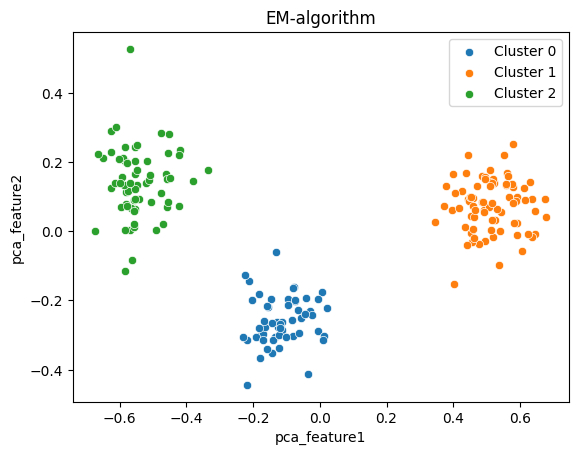

In [167]:
plt.title('EM-algorithm')
plt.xlabel('pca_feature1')
plt.ylabel('pca_feature2')
for i in range(len(clusters_em)):
    sns.scatterplot(x=data_2d[list(clusters_em[i])][:, 0], y=data_2d[list(clusters_em[i])][:, 1],
                    label=f'Cluster {i}')

Кластеризация EM-алгоритмом на двумерных данных для визуализации результатов

In [168]:
gmm = GaussianMixture(n_components=3, covariance_type="full", random_state=54)
gmm.fit(data_2d)
labels = gmm.predict(data_2d)
clusters_em = []
for i in range(3):
    cluster =  np.arange(0, 199)[labels_em == i]
    clusters_em.append(set(cluster))
for i, cluster in enumerate(clusters_em, start=1):
    print(f"Кластер {i}: {sorted(list(map(lambda x: int(x), cluster)))}")

Кластер 1: [6, 7, 12, 13, 14, 15, 17, 27, 29, 31, 32, 33, 43, 48, 49, 54, 59, 65, 66, 71, 73, 74, 76, 78, 79, 82, 87, 94, 97, 98, 105, 107, 110, 111, 125, 126, 130, 131, 132, 142, 147, 148, 155, 156, 158, 159, 160, 167, 169, 170, 171, 175, 178, 182, 186, 189, 196]
Кластер 2: [0, 1, 2, 5, 11, 18, 20, 21, 23, 24, 26, 39, 41, 45, 46, 47, 50, 51, 53, 55, 56, 60, 64, 68, 69, 72, 77, 80, 88, 90, 95, 96, 100, 103, 104, 106, 108, 109, 112, 113, 114, 115, 116, 117, 122, 123, 124, 127, 128, 133, 135, 137, 138, 140, 141, 144, 145, 149, 150, 151, 153, 154, 161, 162, 172, 174, 176, 177, 179, 181, 183, 184, 185, 187, 192, 194, 195, 197, 198]
Кластер 3: [3, 4, 8, 9, 10, 16, 19, 22, 25, 28, 30, 34, 35, 36, 37, 38, 40, 42, 44, 52, 57, 58, 61, 62, 63, 67, 70, 75, 81, 83, 84, 85, 86, 89, 91, 92, 93, 99, 101, 102, 118, 119, 120, 121, 129, 134, 136, 139, 143, 146, 152, 157, 163, 164, 165, 166, 168, 173, 180, 188, 190, 191, 193]


/tmp/ipykernel_10698/78252592.py:8: UserWarning: Log scale: values of z <= 0 have been masked
  CS = plt.contour(


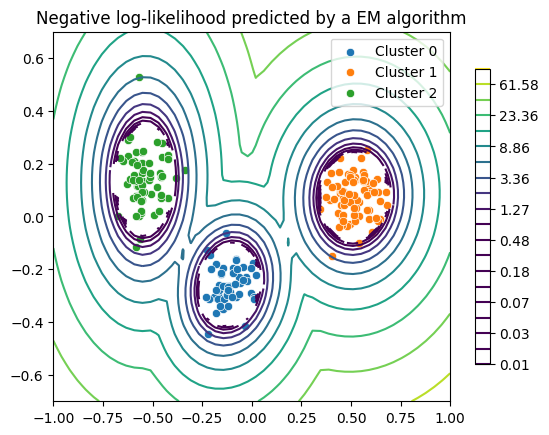

In [169]:
x = np.linspace(-1, 1)
y = np.linspace(-0.7, 0.7)
X_, Y_ = np.meshgrid(x, y)
XX = np.array([X_.ravel(), Y_.ravel()]).T
Z = -gmm.score_samples(XX)
Z = Z.reshape(X_.shape)

CS = plt.contour(
    X_, Y_, Z, norm=LogNorm(vmin=1.0, vmax=100), levels=np.logspace(-2, 2, 20)
)
CB = plt.colorbar(CS, shrink=0.8, extend="both")
# plt.scatter(data_2d[:, 0], data_2d[:, 1], 0.8)
for i in range(len(clusters_em)):
    sns.scatterplot(x=data_2d[list(clusters_em[i])][:, 0], y=data_2d[list(clusters_em[i])][:, 1],
                    label=f'Cluster {i}')

plt.title("Negative log-likelihood predicted by a EM algorithm")
plt.axis("tight")
plt.show()

#### Кластеризация Unnormalized Spectral методом

In [170]:
W = sim_matrix
D = np.diag([W.shape[0] for _ in range(W.shape[0])])
L = D - W

In [171]:
eig_vals, eig_vecs = np.linalg.eigh(L)
eig_vecs_3 = eig_vecs[:, :3]
kmeans = KMeans(n_clusters=3, n_init=50)
labels_spectral = kmeans.fit_predict(eig_vecs_3)
clusters_spectral = []
for i in range(3):
    cluster =  np.arange(0, 199)[labels_spectral == i]
    clusters_spectral.append(set(cluster))
for i, cluster in enumerate(clusters_spectral, start=1):
    print(f"Кластер {i}: {sorted(list(map(lambda x: int(x), cluster)))}")

Кластер 1: [0, 1, 2, 5, 11, 18, 20, 21, 23, 24, 26, 39, 41, 45, 46, 47, 50, 51, 53, 55, 56, 60, 64, 68, 69, 72, 77, 80, 88, 90, 95, 96, 100, 103, 104, 106, 108, 109, 112, 113, 114, 115, 116, 117, 122, 123, 124, 127, 128, 133, 135, 137, 138, 140, 141, 144, 145, 149, 150, 151, 153, 154, 161, 162, 172, 174, 176, 177, 179, 181, 183, 184, 185, 187, 192, 194, 195, 197, 198]
Кластер 2: [3, 4, 8, 9, 10, 16, 19, 22, 25, 28, 30, 34, 35, 36, 37, 38, 40, 42, 44, 52, 57, 58, 61, 62, 63, 67, 70, 75, 81, 83, 84, 85, 86, 89, 91, 92, 93, 99, 101, 102, 118, 119, 120, 121, 129, 134, 136, 139, 143, 146, 152, 157, 163, 164, 165, 166, 168, 173, 180, 188, 190, 191, 193]
Кластер 3: [6, 7, 12, 13, 14, 15, 17, 27, 29, 31, 32, 33, 43, 48, 49, 54, 59, 65, 66, 71, 73, 74, 76, 78, 79, 82, 87, 94, 97, 98, 105, 107, 110, 111, 125, 126, 130, 131, 132, 142, 147, 148, 155, 156, 158, 159, 160, 167, 169, 170, 171, 175, 178, 182, 186, 189, 196]


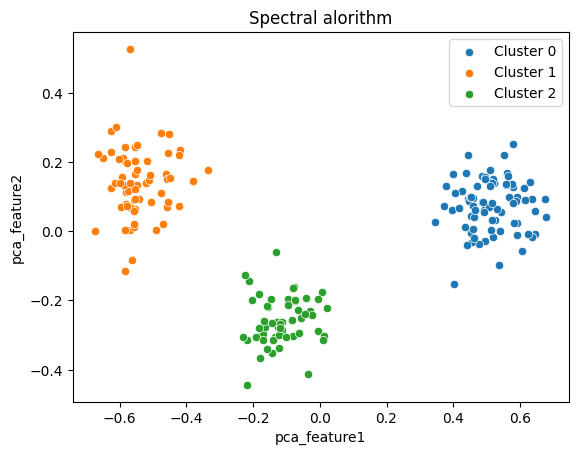

In [172]:
plt.title('Spectral alorithm')
plt.xlabel('pca_feature1')
plt.ylabel('pca_feature2')
for i in range(len(clusters_spectral)):
    sns.scatterplot(x=data_2d[list(clusters_spectral[i])][:, 0], y=data_2d[list(clusters_spectral[i])][:, 1],
                    label=f'Cluster {i}')

#### Подсчет RAND индекса

In [173]:
rand_idx_matrix = np.zeros((5, 5))

for i, m1 in enumerate([clusters_mst, clusters_kmeans, clusters_em, clusters_spectral]):
    for j, m2 in enumerate(
        [clusters_mst, clusters_kmeans, clusters_em, clusters_spectral]
    ):
        rand_idx_matrix[i, j] = get_rand_index(m1, m2)

rand_idx_matrix

array([[1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0.]])

In [174]:
random_partitions = [r_partition(3, 199) for i in range(100)]

In [175]:
for i, m in enumerate([clusters_mst, clusters_kmeans, clusters_em, clusters_spectral]):
    mean_rand_idx_vs_randompart = (
        sum([get_rand_index(m, r) for r in random_partitions]) / 100
    )
    rand_idx_matrix[i, 4] = rand_idx_matrix[4, i] = mean_rand_idx_vs_randompart

In [176]:
rand_idx_matrix[4, 4] = sum([sum([get_rand_index(r1, r2) for r1 in random_partitions]) for r2 in random_partitions]) / 100**2

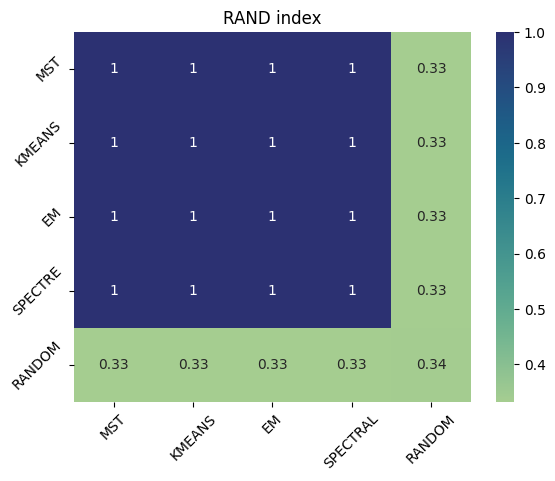

In [177]:
plt.title("RAND index")
g = sns.heatmap(
    rand_idx_matrix,
    annot=True,
    xticklabels=["MST", "KMEANS", "EM", "SPECTRAL", "RANDOM"],
    yticklabels=["MST", "KMEANS", "EM", "SPECTRE", "RANDOM"],
    cmap="crest",
)
if g.get_yticklabels():
    g.set_yticklabels(labels=g.get_yticklabels(), rotation=45)
if g.get_xticklabels():
    g.set_xticklabels(g.get_xticklabels(), rotation=45)

RAND индекс показывает, что все алгоритмы получили одинаковые разбиения.

#### Подсчет функции модулярности

In [183]:
mfn_rand = []

for k in range(0, 100):
    rpart = r_partition(3, 199)
    mfn_rand.append(nx.community.modularity(G, rpart))

In [184]:
for part, part_name in zip(
    [clusters_mst, clusters_kmeans, clusters_em, clusters_spectral],
    ["MST", "KMEANS", "EM", "SPECTRAL"],
):
    print(f"{part_name} clustering modularity value:", nx.community.modularity(G, part))
print("RANDOM clustering modularity value:", sum(mfn_rand) / 100)

MST clustering modularity value: 0.08737324758275604
KMEANS clustering modularity value: 0.08737324758275611
EM clustering modularity value: 0.08737324758275611
SPECTRAL clustering modularity value: 0.08737324758275611
RANDOM clustering modularity value: -0.0034421451016279307


Значения функции модулярности получились близки к нулю, что может говорить о слабой связи между вершинами даже внутри казалось бы очевидных (из двумерной карты кластеров).

#### Подсчет Silhouette Score

In [187]:
sil_rand = []

for k in range(0, 100):
    rpart = r_partition(2, 199)
    sil_rand.append(silhouette_score(Y, get_labels_from_clusters(rpart)))

In [188]:
for part, part_name in zip(
    [clusters_mst, clusters_kmeans, clusters_em, clusters_spectral],
    ["MST", "KMEANS", "EM", "SPECTRAL"],
):
    cur_labels = get_labels_from_clusters(part)
    print(f'{part_name} silhouette score: {silhouette_score(Y, cur_labels)}')
    
print("RANDOM silhouette score:", sum(sil_rand) / 100)

MST silhouette score: 0.6248346252255562
KMEANS silhouette score: 0.6248346252255562
EM silhouette score: 0.6248346252255562
SPECTRAL silhouette score: 0.6248346252255562
RANDOM silhouette score: 0.00016923942549705606


Silhouette score стал выше, чем при разбиении этого набора данных на 2 кластера, что говорит о том, что правильнее делить этот набор наблюдений на 3 кластера.

Также стоит отметить, что в отличие от модулярности, Silhouette является именно относительной метрикой, так как  отражает похожесть элементов на соседей из своего кластера (в сравнении с элементами из других кластеров). Поэтому, даже при том что мы имеем довольно близкое к нулю значение функции модулярности, это не значит что данные случайные и полученные разбиения - неудачные. Значение Silhouette показывает обратное.

## Оценка оптимального количества кластеров известными методами

#### 1) Оценка оптимального количества кластеров методом локтя

Для реализации данного метода, мы кластерезуем наши наблюдения некоторое количество раз варьируя k (количество кластеров от 1 до некоторого верхнего значения). Для каждого k мы считаем WCSS (within-cluster sum of squares) и строим график зависимости WCSS от k.

Суть метода заключается в том, что оптимальное k можно определить по графику: точка, соответсвующая k будет "локтевой", то есть если увеличивать k относительно оптимального, WCSS будет оставаться на плато.

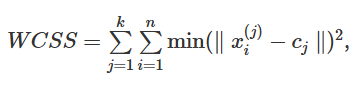

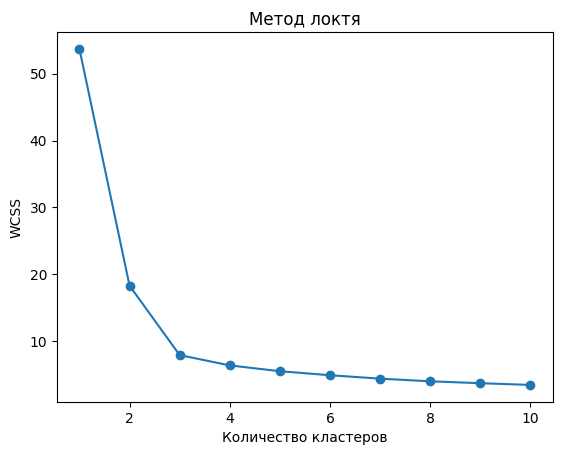

In [180]:
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=50, random_state=54).fit(Y)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('WCSS')
plt.title('Метод локтя')
plt.show()

По графику хорошот видно, что после k=3 WCSS продолжает значительно уменьшаться, что подтверждает предыдущие выводы о том, что оптимальное количество кластеров для этого набора данных - 3.

#### 2) Оценка оптимального количества кластеров с помощью собственных значений нормализованного лапласиана графа

Основываясь на том что кратность собственного значения лапласиана, равного нулю равна количеству компонент связности графа, построим на графике все собственные значения и попытаемся сделать вывод об оптимальном количестве кластеров

In [189]:
D_sq = np.diag([1 / np.sqrt(W.shape[0]) for i in range(W.shape[0])])
Lsym = D_sq @ L @ D_sq
eig_vals_sym, eig_vecs_sym = np.linalg.eigh(Lsym)

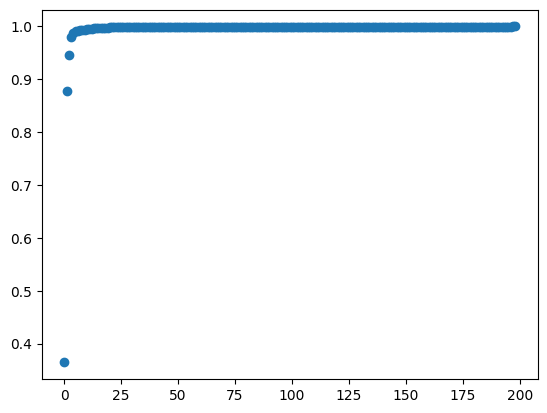

In [190]:
plt.scatter(list(range(len(eig_vals_sym))), eig_vals_sym)

Из графика видно, что самое близкое к нулю собственное значение лапласиана равно примерно 0.35, а следующее собственное значение довольно близко к единице, поэтому данный метод не очень согласуется с нашими предыдущими выводами, хотя конечно можно сказать, что первые 3 собственных значения все же выделяются на графике и это говорит о том, что оптимальные значение для k согласно данному методу - это 3.

Для этого набора данных можно утверждать, что оптимальное количество кластеров - 3, что подтверждается значениями Silhouette, методом локтя и двумерной картой наблюдений. На двумерной карте отчетливо видны 3 кластера, которые были хорошо определены всеми четырьмя опробованными алгоритмами.